In [1]:
os.chdir('/home/xli/Data/Haihui/CD8-HP/HiC/HiC_Data_Summary/edgeR')
os.system('Rscript Run_EdgeR_lx.R -c count_table.txt -i hic_index.txt -o /home/xli/Data/Haihui/CD8-HP/HiC/HiC_Data_Summary/edgeR')

NameError: name 'os' is not defined

In [306]:
class Student(object):

    def __init__(self, name, score):
        self.__name = name
        self.__score = score

    def print_score(self):
        print('%s: %s' % (self.__name, self.__score))
        
    def set_score(self, score):
        if 0 <= score <= 100:
            self.__score = score
        else:
            raise ValueError('bad score')
            
hh = Student('lx',100)
hh.set_score(1)
hh.print_score()
hh._Student__name

lx: 1


'lx'

# Bug 

In [2]:
#This is a bug in the Python interface; _source and _target do not work properly
#on undirected graphs. As a workaround, use g.incident(x) to obtain the IDs of
#the edges incident on vertex x -- this can then be used to subset g.es:
    
# Using g.es[g.incident(idx)] solved

##
# bin format chr1:x1-x2
# corresponding bed format chr1    x1    x2

In [1]:
import pandas as pd
import numpy as np
import igraph as ig
from pybedtools import BedTool
from scipy import stats

In [2]:
#import matplotlib
#matplotlib.use('AGG')
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style("white") 
# display plots in this notebook
%matplotlib inline


### Functions: scatter, box, and enrichment plot 

In [3]:
def hexbin_with_density(df, highlight_name, title_name, density_scale, drop_top_outlier):
    ### drop outlier
    df = df.drop(df.iloc[:,0].nlargest(n=drop_top_outlier,keep='first').index)
    
    
    range_limit=df.max().max()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 9), sharex=False, sharey=False)
    
    if density_scale == 'log':
        hb = ax.hexbin(df.iloc[:,[0]], df.iloc[:,[1]], gridsize=(100,100), cmap=plt.cm.jet,
                   bins='log',mincnt=1,alpha=2, edgecolors='face')
        cb = fig.colorbar(hb,ax=ax)
        cb.set_label('Log$_{10}$(1+Counts)', fontsize=18)
    else:
        hb = ax.hexbin(df.iloc[:,[0]], df.iloc[:,[1]], gridsize=(100,100), cmap=plt.cm.jet,
                   mincnt=1,alpha=2, edgecolors='face')
        cb = fig.colorbar(hb,ax=ax)
        cb.set_label('Counts', fontsize=18)

    ###  highlight a point
    if len(highlight_name) >= 1:
        for highlight_index in highlight_name[:]:
            ax.scatter(df[df.index == highlight_index].iloc[:,[0]],
                        df[df.index == highlight_index].iloc[:,[1]],
                        alpha=1.0,s=50,color='red', label=highlight_index,edgecolor='red')
            ax.text(df[df.index == highlight_index].iloc[:,0]-range_limit/20.0,
                      df[df.index == highlight_index].iloc[:,1]+range_limit/25.0, highlight_index, fontsize=16, color='r')


    ax.yaxis.grid(False)
    ax.set_ylim(-0.1*range_limit,range_limit+0.1*range_limit)
    ax.set_xlim(-0.1*range_limit,range_limit+0.1*range_limit)
    ax.set_xlabel(str(df.columns[0]), fontsize=18)
    ax.set_ylabel(str(df.columns[1]), fontsize=18)
    ax.plot([-0.1*range_limit,range_limit+0.1*range_limit], [-0.1*range_limit, range_limit+0.1*range_limit], ls="--", c="gray")
    ax.set_title(str(len(df))+ ': '+ title_name , fontsize=18)
    return 0

def box_plot_for_haihui(all_data, y_axis_name):
    ### Define Boxplot FrameSize
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2.1+len(all_data)*1.2, 4.6))
    x_rotation=-60
    
    plt.xticks(rotation=x_rotation)
    
    ax.boxplot( all_data, showfliers=False, widths=0.3,
           boxprops=dict(linestyle='-', linewidth=1.5, color='black'), 
           whiskerprops = dict(linestyle='-', linewidth=1.5, color='black'),
           capprops = dict(linestyle='-', linewidth=1.5, color='black'),
           medianprops = dict(linestyle='-', linewidth=1.5, color='red'))
    
    ### Generate X ticks
    xtiks = []
    for i in range(len(all_data)):
        xtiks.append(len(all_data[i]))
        
    plt.setp(ax, xticks=[y + 1 for y in range(len(all_data))], xticklabels=xtiks)



    ### plot size
    ax.spines["left"].set_linewidth(1.5)
    ax.spines["bottom"].set_linewidth(1.5)
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_label_position("bottom")
    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_label_position("left")
    ax.tick_params(axis='x',which='major', direction='out', length=6, labelsize=18, width=1.5)
    ax.tick_params(axis='x',which='minor', direction='out', length=6, labelsize=18, width=1.5)
    ax.tick_params(axis='y',which='major', direction='out', length=6, labelsize=18, width=1.5)
    ax.tick_params(axis='y',which='minor', direction='out', length=6, labelsize=18, width=1.5)

    ax.set_ylabel(y_axis_name, fontsize = 16, fontname="Arial")
    ax.locator_params(nbins=5, axis='y')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return None

def Features_Return_exp_and_obser(PATH_Feature_A, PATH_Region_B, genomeSize, title):
    ### Feature A enrichment in region B
    Feature_A=BedTool(PATH_Feature_A).sort()
    genomeSize=2620345972
    f_ex = len(Feature_A)/genomeSize


    Region_B =BedTool(PATH_Region_B).sort()
    df_Feature_B = pd.read_csv(Region_B.fn, sep="\t", header=None)
    df_Feature_B = df_Feature_B.iloc[:,[0,1,2]].drop_duplicates()
    total_Region_B_length = df_Feature_B.iloc[:,2].sum()-df_Feature_B.iloc[:,1].sum()
    N_ex = f_ex*total_Region_B_length
    N_obser = len(Feature_A.intersect(Region_B, u=True))
    print ("Enriched Feature Number: " + str(N_obser))
    
    Enrichment_Num = N_obser
    Total_Number = len(Feature_A)
    prob_event = N_ex/len(Feature_A)
    print ("Prob: " , prob_event)
    pvalue = stats.binom_test(Enrichment_Num, n=Total_Number, p=prob_event)

    index = [title+str(len(df_Feature_B))]
    df = pd.DataFrame({'observed': N_obser, 'exp': N_ex}, index=index)
    ax = df.plot.bar(rot=0)
    
    plt.title('Obs/Exp Ratio: ' + str(N_obser/N_ex)+ ' Pvalue: '+ str(pvalue))
    return N_ex, N_obser, N_obser/N_ex

## From Interactions to Graph

In [4]:
def Read_Interaction(_PATH_interaction, _resolution, _col_fore, _col_back):
    PATH_interaction=_PATH_interaction
    col_fore = _col_fore
    col_back  = _col_back
    resolution = _resolution
    
    df_interaction = pd.read_csv(PATH_interaction, sep="\t").fillna(0)
    df_interaction = df_interaction[df_interaction.iloc[:,1]!=df_interaction.iloc[:,2]] ### remove self interaction
    df_interaction.loc[:,'#chr']=df_interaction.iloc[:,0].replace('chr','')
    df_interaction.loc[:,'#chr1']=df_interaction.iloc[:,0]
    df_interaction.loc[:,'x1']=df_interaction.iloc[:,1].astype(int)
    df_interaction.loc[:,'x2']=df_interaction.iloc[:,1].astype(int)+int(resolution)
    df_interaction.loc[:,'chr2']=df_interaction.iloc[:,0]
    df_interaction.loc[:,'y1']=df_interaction.iloc[:,2].astype(int)
    df_interaction.loc[:,'y2']=df_interaction.iloc[:,2].astype(int)+int(resolution)

    df_interaction.loc[:,'log_FC'] = np.log2(df_interaction.loc[:,col_fore].replace(0,0.1) / df_interaction.loc[:,col_back].replace(0,0.1) )
    df_interaction = df_interaction.loc[:,['#chr1','x1','x2','chr2','y1','y2','log_FC', col_fore, col_back]]
    return df_interaction

def Convert_Loops_to_Graph(_df_hic, _weight_col):
    ## Assign a list of weight ot graph
    
    ## loop format: ['#chr1', 'x1', 'x2', 'chr2', 'y1', 'y2', 'GeneID', 'weight_cols']
    df_bins = Loops_Return_two_bins_no_dup(_df_hic)
    
    ## eliminate float in chr
    df_bins['name'] = df_bins['#chr1'].astype(str).str.split(".",expand=True)[0]+':'+df_bins['x1'].astype(int).astype(str)+'-'+df_bins['x2'].astype(int).astype(str)
    Num_vs = len(df_bins.index)
    ## Initiation a graph from loops file 
    graph_tem = ig.Graph()
    graph_tem.add_vertices(Num_vs)
    graph_tem.vs["name"] = df_bins.loc[:,'name']
    df_edge = _df_hic.merge(df_bins, on=['#chr1', 'x1', 'x2']).merge(
        df_bins, left_on=['chr2', 'y1', 'y2'], right_on=['#chr1', 'x1', 'x2'])
    graph_tem.add_edges(df_edge.loc[:, ['index_x','index_y']].values)

    for weight in _weight_col:
        if (weight in _df_hic.columns):
            graph_tem.es[weight] = df_edge.loc[:,weight].values
    return graph_tem

def Convert_Loops_to_Graph_bp(df_loops, weight_col, _extra_edge_col):
    ## loop format: ['#chr1', 'x1', 'x2', 'chr2', 'y1', 'y2', 'GeneID', 'weight_cols']
    df_bins = Loops_Return_two_bins_no_dup(df_loops)
    df_bins['name'] = df_bins['#chr1'].astype(str)+':'+df_bins['x1'].astype(int).astype(str)+'-'+df_bins['x2'].astype(int).astype(str)
    Num_vs = len(df_bins.index)
    ## Initiation a graph from loops file 
    graph = ig.Graph()
    graph.add_vertices(Num_vs)
    graph.vs["name"] = df_bins.loc[:,'name']
    
    df_edge = df_loops.merge(df_bins, on=['#chr1', 'x1', 'x2']).merge(
        df_bins, left_on=['chr2', 'y1', 'y2'], right_on=['#chr1', 'x1', 'x2'])
    graph.add_edges(df_edge.loc[:, ['index_x','index_y']].values)
    if weight_col:
        graph.es["weight"] = df_edge.loc[:,weight_col].values
    if _extra_edge_col:
        graph.es[_extra_edge_col] = df_edge.loc[:,_extra_edge_col].values
    return graph

def Loops_Return_two_bins_no_dup(df_hic):
    ## Associated by promoter
    second_bin_columns = [3,4,5,0,1,2]+list(range(6,len(df_hic.columns),1))
    df_hic=df_hic.append(pd.DataFrame(df_hic.iloc[:, second_bin_columns].values, columns=df_hic.columns),sort=False).sort_index()
    return df_hic.iloc[:,0:3].drop_duplicates().reset_index().drop('index',axis=1).reset_index()

def convert_cluster2bed(df_cluster, usecol):
    df_tem = df_cluster[usecol].str.split(r"\:|-",expand=True)
    df_tem = pd.concat( [df_tem, df_cluster], axis=1)
    if (df_tem.iloc[0,0].find('chr') == -1):
        df_tem[0] = 'chr'+df_tem[0]
    return df_tem

def convert_bin2bed(df_cluster, col_name):
    df_tem = df_cluster[col_name].str.split(r"\:|-",expand=True)
    df_tem = pd.concat( [df_tem, df_cluster], axis=1)
    if (df_tem.iloc[0,0].find('chr') == -1):
        df_tem[0] = 'chr'+df_tem[0]
    return df_tem

def convert_vs2bed(input_graph, col_name):
    ## output first 3 columns is standard bed format
    df_tem = pd.DataFrame(data={col_name:input_graph.vs[col_name]})
    df_tem = pd.concat( [df_tem[col_name].str.split(r"\:|-",expand=True),df_tem], axis=1)
    if (df_tem.iloc[0,0].find('chr') == -1):
        df_tem[0] = 'chr'+df_tem[0]
    return df_tem

def convert_graph_vs_to_df(_input_graph):
    #df_vs = pd.DataFrame(data= {"degree":_input_graph.degree()}) # depreciated
    df_vs = pd.DataFrame()
    for col in _input_graph.vs.attributes():
        df_vs[col] = _input_graph.vs[col]

    return df_vs

def graph_community_multilevel_Blondel(input_graph, cutoff):
    ## input graph should have at least one attribute: name
    df_vs = convert_graph_vs_to_df(input_graph)
    _col_vs_name='name'
    if (input_graph.is_weighted()):
        print ("Weighted Graph Cluster")
        structure = input_graph.community_multilevel(weights=input_graph.es['weight'] ,return_levels=False)
    else:
        structure = input_graph.community_multilevel(return_levels=False)
    df_vs['membership'] = structure.membership
    df_vs_cluster_group = df_vs.groupby('membership')
    
    ## Rank each cluster by number of bins
    cluster_name=[]
    cluster_num_vertices=[]
    for df_vs_cluster in df_vs_cluster_group:
        df_vs_inside_cluster = Cluster_Filter_by_Denisty(df_vs_cluster[1], _col_vs_name, 'degree', cutoff)
        #df_vs_inside_cluster =df_vs_cluster[1]
        df_cluster_coordiante = df_vs_inside_cluster[_col_vs_name].str.split(r"\:|-",expand=True)
        cluster_coordinate = 'chr'+df_cluster_coordiante.iloc[0,0]+':'+str(df_cluster_coordiante.iloc[:,1].astype(int).min())+'-'+str(df_cluster_coordiante.iloc[:,2].astype(int).max())
        cluster_name.append(cluster_coordinate) ##0: cluster name
        cluster_num_vertices.append(len(df_vs_inside_cluster)) # 1: num_vertices
    
    df_cluster_output = pd.DataFrame(data={'hub_name':cluster_name,'Num_vertices':cluster_num_vertices}).sort_values('Num_vertices', ascending=False)
    return df_cluster_output, df_vs_cluster_group

def Graph_Pagerank(_input_graph):
    input_graph = _input_graph
    input_graph.vs['pagerank'] = input_graph.pagerank(weights=input_graph.es['weight'])
    return input_graph

def graph_community_multilevel_Blondel_diff_level(input_graph, cutoff):
    ## input graph should have at least one attribute: name
    df_vs = convert_graph_vs_to_df(input_graph)
    _col_vs_name='name'
    
    if (input_graph.is_weighted()):
        print ("Weighted Graph Cluster")
        structure = input_graph.community_multilevel(weights=input_graph.es['weight'], return_levels=True)
    else:
        structure = input_graph.community_multilevel(return_levels=True)
    
    for tem_level in structure:
        print (tem_level.summary())
    df_vs['membership'] = structure[0].membership
    df_vs_cluster_group = df_vs.groupby('membership')
    
    ## Rank each cluster by number of bins
    cluster_name=[]
    cluster_num_vertices=[]
    for df_vs_cluster in df_vs_cluster_group:
        df_vs_inside_cluster = Cluster_Filter_by_Denisty(df_vs_cluster[1], _col_vs_name, 'degree', cutoff)
        if (len(df_vs_inside_cluster)>0):
            df_cluster_coordiante = df_vs_inside_cluster[_col_vs_name].str.split(r"\:|-",expand=True)
            #print (df_cluster_coordiante)
            cluster_coordinate = 'chr'+df_cluster_coordiante.iloc[0,0]+':'+str(df_cluster_coordiante.iloc[:,1].astype(int).min())+'-'+str(df_cluster_coordiante.iloc[:,2].astype(int).max())
            cluster_name.append(cluster_coordinate) ##0: cluster name
            cluster_num_vertices.append(len(df_vs_inside_cluster)) # 1: num_vertices
    
    df_cluster_output = pd.DataFrame(data={'hub_name':cluster_name,'Num_vertices':cluster_num_vertices}).sort_values('Num_vertices', ascending=False)
    return df_cluster_output, df_vs_cluster_group


def graph_community_multilevel_Blondel_diff_level_promoter(input_graph, cutoff):
    ## input graph should have at least one attribute: name
    df_vs = convert_graph_vs_to_df(input_graph)
    _col_vs_name='name'
    
    if (input_graph.is_weighted()):
        print ("Weighted Graph Cluster")
        structure = input_graph.community_multilevel(weights=input_graph.es['weight'], return_levels=True)
    else:
        structure = input_graph.community_multilevel(return_levels=True)
    
    for tem_level in structure:
        print (tem_level.summary())
    df_vs['membership'] = structure[0].membership
    df_vs_cluster_group = df_vs.groupby('membership')
    
    ## Rank each cluster by number of bins
    cluster_summary = []
    for df_vs_cluster in df_vs_cluster_group:
        df_cluster = df_vs_cluster[1] 
        if( len(df_cluster[df_cluster['Promoter']!=0])>0):
            for promoter_id in df_cluster[df_cluster['Promoter']!=0]['Promoter_gene_id'].unique():#[0]
                #promoter_id = df_cluster[df_cluster['Promoter']!=0]['Promoter_gene_id'].unique()[0]
                #print(promoter_id)
                if (promoter_id=='Myb'):
                    df_test_out = df_cluster
                df_vs_inside_cluster, cluster_coordinate = Cluster_Filter_by_Denisty_Promoter(df_cluster, _col_vs_name, promoter_id, cutoff)            
                cluster_summary.append( [cluster_coordinate, len(df_vs_inside_cluster), promoter_id])
                
    
    df_cluster_output = pd.DataFrame(data=cluster_summary, columns=['hub_name','Num_vertices','Promoter']).sort_values('Num_vertices', ascending=False)
    return df_cluster_output, df_vs_cluster_group, df_test_out

## Depreciated Shrink Method

In [5]:
def Cluster_Filter_by_Denisty(_df_vs_cluster, _col_name, _core_col, _cutoff):
    ## Linear Denisty Threshold, 1 edge at least 1 anchor
    cutoff=_cutoff#0.5
    df_tem = _df_vs_cluster
    col_name='name'
    _core_col='pagerank'
    resolution=10000
    df_tem[col_name].str.split(r"\:|-",expand=True)
    df_tem = pd.concat( [df_tem[col_name].str.split(r"\:|-",expand=True),df_tem], axis=1)

    ## Define highest degree as summit
    num_core = 1
    core = df_tem.nlargest(int(num_core), _core_col).iloc[:,1].astype(int).mean()
    df_tem['density'] = df_tem['degree'].astype(float)/(abs(df_tem.iloc[:,1].astype(float)-float(core))**2)*resolution**2

    return df_tem[df_tem['density']>cutoff]

def Cluster_Filter_by_Denisty_Promoter(_df_vs_cluster, _col_name, _promoter_id, _cutoff):
    ## Linear Denisty Threshold, 1 edge at least 1 anchor
    cutoff=_cutoff#0.5
    df_tem = _df_vs_cluster
    col_name='name'
    promoter_id = _promoter_id
    resolution=10000
    df_tem[col_name].str.split(r"\:|-",expand=True)
    df_tem = pd.concat( [df_tem[col_name].str.split(r"\:|-",expand=True),df_tem], axis=1)
    
    ## Define Target Promoter as core
    core = df_tem[df_tem['Promoter_gene_id']==promoter_id].iloc[:,1:3].astype(int).sum(axis=1)/2
    #print (core)

    df_tem['density'] = df_tem['degree'].astype(float)/(abs(df_tem.iloc[:,1].astype(float)-float(core))**2)*resolution**2
    df_filtered_cluster_elements = df_tem[df_tem['density']>cutoff]
    
    df_cluster_coordiante = df_filtered_cluster_elements[col_name].str.split(r"\:|-",expand=True)
    
    cluster_coordinate = 'chr'+df_cluster_coordiante.iloc[0,0]+':'+str(df_cluster_coordiante.iloc[:,1].astype(int).min())+'-'+str(df_cluster_coordiante.iloc[:,2].astype(int).max())
    
    
    return df_filtered_cluster_elements, cluster_coordinate

In [6]:
def display_graph_vertex(input_graph, vs_idx_set):
    # Input graph and Input vertex index set
    for vs in graph_processed.vs.select(vs_idx_set):
        print ( "vs_idx:"+ str(vs.index)+ ' '+ str(vs.attributes()))
    return None
def display_graph_edge(input_graph, vs_idx_set):
    # Input graph and Input vertex index set
    for vs_idx in vs_idx_set:
        edges_from_vs = input_graph.es[input_graph.incident(vs_idx)]
        for es in edges_from_vs:
            print ( "es_idx:"+ str(es.index)+ ' '+ str(es.tuple))
    return None

def annotate_graph_with_feature_values_new(_input_graph, graph_name_col2bed, path_feature, feature_name, _feature_score, norm_factor=1.0):
    input_graph = _input_graph
    name_col2bed = graph_name_col2bed ## Default "name"
    Vs_Attrs_Name = feature_name ## such as 'Tcf1'
    if ( Vs_Attrs_Name not in input_graph.vs.attributes()):
        ## Convert vs to bed format in order to annotate
        df_vs_bed = convert_vs2bed(input_graph, name_col2bed)
        ### df_vs_bed to be annoted
        df_vs_bed.iloc[:,0]='chr'+ df_vs_bed.iloc[:,0].astype(str)
        Feature_vs = BedTool.from_dataframe(df_vs_bed).sort()

        PATH_Feature_A = path_feature ##
        df_A = pd.read_csv(PATH_Feature_A, sep="\t")
        Feature_A = BedTool.from_dataframe(df_A).sort()

        ## annotate A in vs
        Feature_vs_with_A = Feature_vs.intersect(Feature_A, wb=True, F=0.3) ## 30% maybe enough

        if (len(Feature_vs_with_A)>0):
            df_vs_with_A=pd.read_csv(Feature_vs_with_A.fn, sep="\t", names=df_vs_bed.columns.append(df_A.columns).values, header=None)
        else:
            df_vs_with_A=pd.DataFrame(columns=df_vs_bed.columns.append(df_A.columns))
        
        
        vs_score = _feature_score  ## 'such as logFC'
        vs_attrs_score = feature_name+'_'+vs_score
        input_graph.vs[Vs_Attrs_Name]=0
        input_graph.vs[vs_attrs_score]=0

        for df_vs in df_vs_with_A.groupby(name_col2bed): ### Default Define vertex attribute "name"
            input_graph.vs.select(name=df_vs[0])[Vs_Attrs_Name] = df_vs[1].shape[0]
            ### max Tcf1 binding
            if ( type(df_vs[1].loc[:,vs_score].head(1).values[0]) == str):
                input_graph.vs.select(name=df_vs[0])[vs_attrs_score] = df_vs[1].loc[:,vs_score].max()
            else:
                #print(df_vs[1].loc[:,vs_score])
                if (df_vs[1].shape[0]==1):
                    input_graph.vs.select(name=df_vs[0])[vs_attrs_score] = df_vs[1].loc[:,vs_score].values[0]/norm_factor
                else:
                    List_Feature = list(df_vs[1].loc[:,vs_score].values)
                    input_graph.vs.select(name=df_vs[0])[vs_attrs_score] = List2Str(List_Feature, norm_factor)#multiple save as str

        print ("Annotate " + Vs_Attrs_Name + " is finished.")
    else: 
        print ("Feature of " + Vs_Attrs_Name + " is already annoated. Skip.")
    
    return input_graph

def annotate_graph_with_feature_values(_input_graph, graph_name_col2bed, path_feature, feature_name, _feature_score):
    input_graph = _input_graph
    name_col2bed = graph_name_col2bed ## Default "name"
    Vs_Attrs_Name = feature_name ## such as 'Tcf1'
    if (Vs_Attrs_Name not in _input_graph.vs.attributes()):
        ## Convert vs to bed format in order to annotate
        df_vs_bed = convert_vs2bed(input_graph, name_col2bed)
        ### df_vs_bed to be annoted
        Feature_vs = BedTool.from_dataframe(df_vs_bed).sort()

        PATH_Feature_A = path_feature ##
        df_A = pd.read_csv(PATH_Feature_A, sep="\t")
        Feature_A = BedTool.from_dataframe(df_A).sort()

        ## annotate A in vs
        Feature_vs_with_A = Feature_vs.intersect(Feature_A, wb=True, F=0.3)

        if (len(Feature_vs_with_A)>0):
            df_vs_with_A=pd.read_csv(Feature_vs_with_A.fn, sep="\t", names=df_vs_bed.columns.append(df_A.columns).values, header=None)
        else:
            df_vs_with_A=pd.DataFrame(columns=df_vs_bed.columns.append(df_A.columns))
        
        
        vs_score = _feature_score  ## 'such as logFC'
        vs_attrs_score = Vs_Attrs_Name+'_'+vs_score
        input_graph.vs[Vs_Attrs_Name]=0
        input_graph.vs[vs_attrs_score]=0
        for df_vs in df_vs_with_A.groupby(name_col2bed): ### Default Define vertex attribute "name"
            input_graph.vs.select(name=df_vs[0])[Vs_Attrs_Name] = df_vs[1].shape[0]
            ### max Tcf1 binding
            if ( type(df_vs[1].loc[:,vs_score].head(1).values[0]) == str):
                input_graph.vs.select(name=df_vs[0])[vs_attrs_score] = df_vs[1].loc[:,vs_score].max()
            else:
                #print(df_vs[1].loc[:,vs_score])
                input_graph.vs.select(name=df_vs[0])[vs_attrs_score] = df_vs[1].loc[:,vs_score].mean()
        print ("Annotate " + Vs_Attrs_Name + " is finished.")
    else: 
        print ("Feature of " + Vs_Attrs_Name + " is already annoated. Skip.")
    
    return input_graph

def Return_Graph_of_Gene(_input_graph, _gene, _search_depth):
    search_depth=_search_depth
    graph_input = _input_graph
    gene_request = _gene
    vertex_set=set()
    if ( len(graph_input.vs.select(Promoter_gene_id=gene_request))>0 ):
        vertex_set.add(graph_input.vs.select(Promoter_gene_id=gene_request)[0].index)
        final_subgrapph=None
        for i in range(search_depth):
            for vertex_index in list(vertex_set):
                graph_select_edges = graph_input.es[graph_input.incident(vertex_index)]
                for edge_in_graph in graph_select_edges:
                    vertex_set.add(edge_in_graph.tuple[0])
                    vertex_set.add(edge_in_graph.tuple[1])

            #print (vertex_set)
            final_subgrapph = graph_input.induced_subgraph(vertex_set)
    else:
        print ('Gene Not Included!')
        final_subgrapph=None
    
    return final_subgrapph

def Visualization_Graph_bp(_sub_graph_test, _plot_name):
    ### Mark Promoter in graph with gene_id
    sub_graph_test = _sub_graph_test
    #sub_graph_test.vs.select(Promoter_gt=0)['label'] = sub_graph_test.vs.select(Promoter_gt=0)['Promoter_gene_id']

    #color_dict = {"Tcf1":"red", "None": "gray"}
    #shape_dict ={'Promoter': 'circular', 'Enhancer':'arrow-up', 'Enhancer_Down':'arrow-down',
    #'Enhancer_Up':'arrow-up', 'None':'hidden'} 

## Default
    sub_graph_test.vs["color"] = "gray"
    #sub_graph_test.vs["shape"] = "hidden"

    # high priority will be put in the end
    if ( 'K27ac' in sub_graph_test.vs.attributes()):
        sub_graph_test.vs.select(K27ac_gt=0)["shape"] = 'diamond'
        #sub_graph_test.vs.select(K27ac_gt=0)['label'] = ["{:.2f}".format(x) for x in sub_graph_test.vs.select(K27ac_gt=0)['K27ac_logFC']]
    
    ## DNase Priority 2
    if ( 'DNase' in sub_graph_test.vs.attributes()):
        sub_graph_test.vs.select(DNase_FC_logFC_gt=0)["shape"] = 'arrow-up'
        sub_graph_test.vs.select(DNase_FC_logFC_lt=0)["shape"] = 'arrow-down'
        sub_graph_test.vs.select(DNase_gt=0)["size"] = [abs(x) * 20 for x in sub_graph_test.vs.select(DNase_gt=0)['DNase_FC_logFC']]
    
    ## Promoter Priority 1
    if ( 'Promoter' in sub_graph_test.vs.attributes()):
        sub_graph_test.vs.select(Promoter_gt=0)["shape"] = 'circular'
        sub_graph_test.vs.select(Promoter_gt=0)['label'] = sub_graph_test.vs.select(Promoter_gt=0)['Promoter_gene_id']
        sub_graph_test.vs.select(Promoter_gt=0)["size"] = 20
        ## convert Genomic Region to shape code 
    if ( 'Tcf1' in sub_graph_test.vs.attributes()):
        sub_graph_test.vs.select(Tcf1_gt=0)["color"] = "red"

    sub_graph_test.vs['name']=''
    graph_plot_saveas(sub_graph_test, _plot_name+'.PNG')
    
    return sub_graph_test
### End of Visulization

## Stitch Region 

In [7]:
def Calculate_Pvalue_for_Hub(_PATH_interaction, _df_Hubs, _col_fore, _col_back):
## Depreciated after using stipes to calculate pvalues 02/05/2021
    ## Calculate pvalue for each hub
    PATH_interaction = _PATH_interaction
    col_fore = _col_fore
    col_back  = _col_back
    df_Hub_top = convert_cluster2bed(_df_Hubs, 'hub_name').reset_index().drop('index', axis=1)
    
    ## Associated each Hub with interaction and pvalue
    ########################################################################################################
    df_inter = pd.read_csv(PATH_interaction, sep="\t").fillna(0)
    df_inter = df_inter[df_inter.iloc[:, 1]!=df_inter.iloc[:, 2]]
    df_inter.loc[:,'#chr']= 'chr'+df_inter.iloc[:,0].astype(str)
    Feature_interaction = BedTool.from_dataframe(df_inter).sort()
    Feature_hub = BedTool.from_dataframe(df_Hub_top).sort()
    ########################################################################################################
    ## calculate all interactions inside a hub
    Feature_Hub_interaction = Feature_hub.intersect(Feature_interaction, wa=True, wb=True, F=1.0)
    col_name = df_Hub_top.columns.append(df_inter.columns)
    df_Feature_Hub_interaction = pd.read_csv(Feature_Hub_interaction.fn, sep='\t', names=col_name)
    df_Feature_Hub_interaction_group = df_Feature_Hub_interaction.groupby('hub_name')

    ########################################################################################################
    ### calculate a pvalue for each hub
    hub_sum=[]
    for hub in df_Feature_Hub_interaction_group:
        #print (hub[0])
        df_hub = hub[1]
        data_for_test = df_hub.loc[:, col_fore]-df_hub.loc[:, col_back]
        w, pvalue_hub = stats.wilcoxon(data_for_test, alternative='greater')
        hub_sum.append([hub[0],  pvalue_hub])
        #break

    df_hub_summary = pd.DataFrame( data = hub_sum, columns=['hub_name', 'pvalue'])
    df_hub_summary = df_Hub_top.merge(df_hub_summary, on=['hub_name'], how='inner').sort_values(by='pvalue')
    
    return df_hub_summary

### allow a gap size of one window

def Stich_Region_Above_Mean_df(_df_hub, _resolution, _gap_size):
    resolution=_resolution
    
    df_nodes = _df_hub.loc[:, [0,1,2,'pagerank']]
    df_nodes[1] = df_nodes[1].astype(int)
    df_nodes = df_nodes.sort_values(by=1)
    df_nodes = df_nodes[df_nodes['pagerank'] > df_nodes['pagerank'].mean()] ## Only use nodes > mean
    
    ## report stich regions
    Report_list=[]
    reg_chr = str(df_nodes.iloc[0,0])
    reg_start= int(df_nodes.iloc[0,1])
    reg_end = int(reg_start)
    
    for bin1 in df_nodes.iloc[:,1].astype(int):
        if (bin1-reg_end)<=_gap_size*resolution:
            reg_end = bin1
        else:
            Report_list.append([reg_chr+':'+str(reg_start)+'-'+str(reg_end+resolution), _gap_size])
            reg_start = bin1
            reg_end = bin1
    Report_list.append([reg_chr+':'+str(reg_start)+'-'+str(reg_end+resolution), _gap_size])
    
    return pd.DataFrame(data=Report_list, columns=['hub_name', 'merge_level'])

def Stich_Region_Above_Mean(_graph, _resolution, _gap_size):
    resolution=_resolution
    graph_pagerank = Graph_Pagerank(_graph)
    df_vs_graph = convert_graph_vs_to_df(graph_pagerank)
    df_nodes = convert_cluster2bed(df_vs_graph, 'name')
    df_nodes[1] = df_nodes[1].astype(int)
    df_nodes = df_nodes.sort_values(by=1)
    df_nodes = df_nodes[df_nodes['pagerank'] > df_nodes['pagerank'].mean()] ## Only use nodes > mean
    
    ## report stich regions
    Report_list=[]
    reg_chr = str(df_nodes.iloc[0,0])
    reg_start= int(df_nodes.iloc[0,1])
    reg_end = int(reg_start)
    
    for bin1 in df_nodes.iloc[:,1].astype(int):
        if (bin1-reg_end)<=_gap_size*resolution:
            reg_end = bin1
        else:
            Report_list.append([reg_chr+':'+str(reg_start)+'-'+str(reg_end+resolution), _gap_size])
            reg_start = bin1
            reg_end = bin1
    Report_list.append([reg_chr+':'+str(reg_start)+'-'+str(reg_end+resolution), _gap_size])
    
    return pd.DataFrame(data=Report_list, columns=['hub_name', 'merge_level'])


def Stich_Region_Above_Mean_Levels(_graph, _resolution):
    
    ### This can be update to improve computation time.
    
    resolution=_resolution
    graph_pagerank = Graph_Pagerank(_graph)
    df_vs_graph = convert_graph_vs_to_df(graph_pagerank)
    df_nodes = convert_cluster2bed(df_vs_graph, 'name').sort_values(by=1)
    df_nodes = df_nodes[df_nodes['pagerank'] > df_nodes['pagerank'].mean()] ## Only use nodes > mean
    
    ## report stich regions
    Report_list=[]

    Num_hubs_ref=0
    for gap_size in range(2,3,1):
        Num_hubs=0
        reg_chr = str(df_nodes.iloc[0,0])
        reg_start= int(df_nodes.iloc[0,1])
        reg_end = reg_start
        for bin1 in df_nodes.iloc[:,1]:
            if (bin1-reg_end)<=gap_size*resolution:
                reg_end = bin1
            else:
                Report_list.append([reg_chr+':'+str(reg_start)+'-'+str(reg_end+resolution)])
                Num_hubs+=1
                reg_start = bin1
                reg_end = bin1
        Report_list.append([reg_chr+':'+str(reg_start)+'-'+str(reg_end+resolution)])
        Num_hubs+=1
        if(Num_hubs==Num_hubs_ref):break
        else:
            Num_hubs_ref=Num_hubs
            continue
    #Return hub with different gap size
    #pd.DataFrame(data=Report_list, columns=['hub_name', 'gap_size']).iloc[:-Num_hubs,:]
    return pd.DataFrame(data=Report_list, columns=['hub_name']).iloc[:-Num_hubs,:].drop_duplicates()


def Graph_Multilevel_Community_Stitch(_input_graph, _gapsize, _resolution):  
    if (_input_graph.is_weighted()):
        print ("Weighted Graph Cluster")
        structure = _input_graph.community_multilevel(weights=_input_graph.es['weight'], return_levels=True)
    else:
        structure = _input_graph.community_multilevel(return_levels=True)
    
    for tem_level in structure:
        print (tem_level.summary())
    
    df_membership = pd.DataFrame(data=structure[0].membership)
    df_membership[0].value_counts().index
    ### Stich according to pagerank locally
    df_hubs_out = pd.DataFrame(columns=['hub_name'])

    i=0
    for graph_tem in structure[0].subgraphs(): # subgraphs() is much faster than using subgraph(idx)
        if (len(graph_tem.vs)>_gapsize+1): ## #_nodes shoud be > _gapsize
            i+=1
            df_hubs = Stich_Region_Above_Mean(graph_tem, _resolution, _gapsize)  ## approximaltly 0.1s for each graph
            df_hubs_out = df_hubs_out.append(df_hubs)
        #if(i==1000):break
    return df_hubs_out

def Graph_Multilevel_Community_Stitch(_input_graph, _gapsize, _resolution):  
    if (_input_graph.is_weighted()):
        print ("Weighted Graph Cluster")
        structure = _input_graph.community_multilevel(weights=_input_graph.es['weight'], return_levels=True)
    else:
        structure = _input_graph.community_multilevel(return_levels=True)
    
    for tem_level in structure:
        print (tem_level.summary())
    
    df_membership = pd.DataFrame(data=structure[0].membership)
    df_membership[0].value_counts().index
    ### Stich according to pagerank locally
    df_hubs_out = pd.DataFrame(columns=['hub_name'])

    i=0
    for graph_tem in structure[0].subgraphs(): # subgraphs() is much faster than using subgraph(idx)
        if (len(graph_tem.vs)>_gapsize+1): ## #_nodes shoud be > _gapsize
            i+=1
            df_hubs = Stich_Region_Above_Mean(graph_tem, _resolution, _gapsize)  ## approximaltly 0.1s for each graph
            df_hubs_out = df_hubs_out.append(df_hubs)
        #if(i==1000):break
    return df_hubs_out

def Stich_Region_Above_Mean_df(_df_nodes, _resolution, _gap_size):
    resolution=_resolution
    df_nodes = convert_cluster2bed(_df_nodes, 'name')
    df_nodes = df_nodes.loc[:, [0,1,2,'pagerank']]
    df_nodes[1] = df_nodes[1].astype(int)
    df_nodes = df_nodes.sort_values(by=1)
    df_nodes = df_nodes[df_nodes['pagerank'] > df_nodes['pagerank'].mean()] ## Only use nodes > mean
    
    ## report stich regions
    Report_list=[]
    reg_chr = str(df_nodes.iloc[0,0])
    reg_start= int(df_nodes.iloc[0,1])
    reg_end = int(reg_start)
    
    for bin1 in df_nodes.iloc[:,1].astype(int):
        if (bin1-reg_end)<=_gap_size*resolution:
            reg_end = bin1
        else:
            Report_list.append([reg_chr+':'+str(reg_start)+'-'+str(reg_end+resolution), _gap_size])
            reg_start = bin1
            reg_end = bin1
    Report_list.append([reg_chr+':'+str(reg_start)+'-'+str(reg_end+resolution), _gap_size])
    
    return pd.DataFrame(data=Report_list, columns=['hub_name', 'merge_level'])

def Stich_Region_Above_global_Mean(_graph, _resolution, _gap_size, _mean):
    resolution=_resolution
    df_vs_graph = convert_graph_vs_to_df(_graph)
    df_nodes = convert_cluster2bed(df_vs_graph, 'name')
    df_nodes[1] = df_nodes[1].astype(int)
    df_nodes = df_nodes.sort_values(by=1)
    df_nodes = df_nodes[df_nodes['pagerank'] > _mean] ## Only use nodes > mean
    Report_list=[]
    if (len(df_nodes)>0):
        ## report stich regions
        
        reg_chr = str(df_nodes.iloc[0,0])
        reg_start= int(df_nodes.iloc[0,1])
        reg_end = int(reg_start)

        for bin1 in df_nodes.iloc[:,1].astype(int):
            if (bin1-reg_end)<=_gap_size*resolution:
                reg_end = bin1
            else:
                Report_list.append([reg_chr+':'+str(reg_start)+'-'+str(reg_end+resolution), _gap_size])
                reg_start = bin1
                reg_end = bin1
        Report_list.append([reg_chr+':'+str(reg_start)+'-'+str(reg_end+resolution), _gap_size])
    return pd.DataFrame(data=Report_list, columns=['hub_name', 'merge_level'])

## for Stripe

In [33]:
def Return_Sorted_Adjacency_Matrix(_graph, _attr):
    
    ## Sort by coordinate
    graph_tem = _graph
    attr      =_attr
    idx_name = [int(str(x).split(":")[1].split("-")[0]) for x in graph_tem.vs['name']]
    
    matrix_tem = pd.DataFrame(data=graph_tem.get_adjacency(attribute=attr), columns=idx_name, index=idx_name)
    df_reindex = pd.DataFrame(data={ 'rank': (stats.rankdata(matrix_tem.columns)-1).astype(int)})
    idx_rank = df_reindex.sort_values(by='rank').index
    ## reference https://wil.yegelwel.com/cluster-correlation-matrix/
    return matrix_tem.iloc[idx_rank, :].T.iloc[idx_rank, :]

def Pvalue_Rank_Test_Matrix(_matirx):
    matrix_for_test = _matirx
    
    data_test = matrix_for_test.fillna(0).values.flatten() ## flatten 2d into 1D
    if (len(data_test)>10):
        w, pvalue =stats.wilcoxon(data_test, zero_method='zsplit', alternative='greater', correction=True, mode='approx')  
        # “zsplit”: Includes zero-differences in the ranking process and split the zero rank between positive and negative ones.
    else:
        pvalue=1.0
    return pvalue

def Return_Hubs_For_Given_Graph(_df_region, _resolution, _matrix):
    df_region = _df_region
    df_regionh_bed = convert_cluster2bed(df_region, 'hub_name').sort_values(by=1)
    resolution = _resolution
    matrix_for_test = _matrix
    
    ## convert each region into bins
    idx_regs = []
    for name_stitch in df_region.hub_name:
        region_loc= name_stitch.split(":")[1].split("-")
        ## store each stitched region with bins 
        idx_regs.append(list(range( int(region_loc[0]), int(region_loc[1])+int(resolution), int(resolution) )))
        
    pvalue_stripe= []
    for i in range(len(idx_regs)):
        part_matrix_for_test = matrix_for_test.loc[idx_regs[i],:].T.loc[idx_regs[i], :]
        pvalue_tem = Pvalue_Rank_Test_Matrix(part_matrix_for_test)
        pvalue_stripe.append([df_region.hub_name[i], -np.log10(pvalue_tem)])

    return pd.DataFrame(data=pvalue_stripe, columns=['hub_name', '-log10(pvalue)']).sort_values('-log10(pvalue)', ascending=False)

def Return_Pvalue_For_Given_Graph(_df_region, _resolution, _matrix):
    df_region = _df_region
    df_regionh_bed = convert_cluster2bed(df_region, 'hub_name').sort_values(by=1)
    resolution = _resolution
    matrix_for_test = _matrix
    
    ## convert each region into bins
    idx_regs = []
    for name_stitch in df_region.hub_name:
        region_loc= name_stitch.split(":")[1].split("-")
        idx_reg = []
        for idx in matrix_for_test.index:
            if ((idx>=int(region_loc[0]))&(idx<=int(region_loc[1]))):
                idx_reg.append(idx)
        idx_regs.append(idx_reg)

    pvalue_region= []
    for i in range(len(idx_regs)):
        for j in range(i+1):
            part_matrix_for_test = matrix_for_test.loc[idx_regs[i],:].T.loc[idx_regs[j], :]
            pvalue_tem = Pvalue_Rank_Test_Matrix(part_matrix_for_test)
            pvalue_region.append([df_region.hub_name[i],df_region.hub_name[j],-np.log10(pvalue_tem)])


    return pd.DataFrame(data=pvalue_region, columns=['reg1', 'reg2', '-log10(pvalue)']).sort_values('-log10(pvalue)', ascending=False)


In [9]:
def Generate_All_Genes(Input_Path, number):
#### READ FILE
    df = pd.read_csv(Input_Path+'/gene_exp.diff', sep='\t', header=0, usecols={'test_id',\
    'status','sample_1','sample_2','value_1','value_2','log2(fold_change)','p_value','q_value'})
#### Rename columns
    df=df.rename(columns={'test_id':'gene_id', 'value_1': df['sample_1'].unique()[0], 'value_2': df['sample_2'].unique()[0]})
#### Output   
    return df.loc[:,['gene_id',df['sample_1'].unique()[0],df['sample_2'].unique()[0],'log2(fold_change)',
                     'p_value','q_value', 'End_'+str(number), '||']].fillna('')

def Predict_expression_mode1(input_graph):
    ## Input Graph must have attributes: "region", "binding"
    vs_promoter = input_graph.vs.select(region="Promoter")
    output_gene_with_score=list()
    for vertex in vs_promoter:
        edges_from_vs = input_graph.es[input_graph.incident(vertex.index)]
        vs_subgraph=edges_from_vs.subgraph()
        test_score = 0 ## for a single promoter vertex define a expression score
        for vs_region, vs_binding in zip(vs_subgraph.vs['region'], vs_subgraph.vs['binding']):
            #print (vs_region,vs_binding)
            if (vs_region == 'Enhancer_Down'): test_score+=(-1)
            elif (vs_region == 'Enhancer_Up'): test_score+=1
            if ( vs_binding=='Tcf1'): test_score*=2
            ## end
        output_gene_with_score.append( [vertex['label'], test_score])
    return output_gene_with_score

In [9]:
#four-character long code, 
#the number of vertices
#the number of edges
#two dashes (–)
#the name of the graph

In [343]:
## basic 
#g.add_vertices(3)
#g.add_edges([(0,1), (1,2)])
#g.delete_edges(edge_id)
#g.delete_vertices()
#g.get_eid(0, 1)
#g.delete_edges(1)
g = Graph([(0,1), (0,2), (2,3), (3,4), (4,2), (2,5), (5,0), (6,3), (5,6)])
#g.add_vertices(3)
g.get_edgelist()
g.vs["name"] = ["Alice", "Bob", "Claire", "Dennis", "Esther", "Frank", "George", "F"]
g.es["weight"] = [1,3,5,7,9,11,13,15,17]
g.summary()

'IGRAPH UNW- 7 9 -- \n+ attr: name (v), weight (e)'

In [ ]:
## Important Operation
print (return_graph.vs[vs_left])
print (return_graph.vs[vs_right])
print (edge)

236.64319132398464


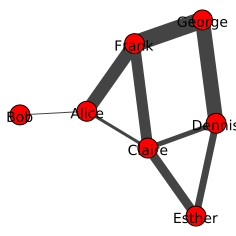

In [9]:
## plot in jupyter notebook
g_for_plot = g

visual_style = {}
Num_vertex=len(g_for_plot.vs())
vertex_size=20
visual_style["vertex_size"] = vertex_size
#visual_style["vertex_color"] = [color_dict[gender] for gender in g.vs["gender"]]
if ("name" in g_for_plot.vs.attributes()):
    visual_style["vertex_label"] = g_for_plot.vs["name"]
if ("weight" in g_for_plot.es.attributes()):
    visual_style["edge_width"] = g_for_plot.es["weight"]#list(preprocessing.scale(g_for_plot.es["weight"])) 
    #preprocessing.scale(g.es["weight"]) 
    #g_for_plot.es["weight"]#list(np.log(g_for_plot.es["width"]))
visual_style["layout"] = g_for_plot.layout("kk")

len_box=(20*Num_vertex*(vertex_size**2))**0.5
print (len_box)
visual_style["bbox"] = (len_box, len_box)
visual_style["margin"] = 20

plot(g_for_plot,**visual_style)

# Convert Bedpe to graph

In [9]:
PATH_FEATURES='/home/xli/Data/Haihui/CD8-HP/Summary/'
PATH_interaction=PATH_FEATURES+'H_4604308_hic_pooled_interaction_KR_Sum_gt10.bed'

#PATH_interaction = '/home/xli/Data/Shaoqi/Hub/chr10_WT_na-DKO_na_2016.bed'

col_fore = 'DKO'
col_back  = 'WT'
resolution = int(10000)

df_hic = Read_Interaction(PATH_interaction, resolution, col_fore, col_back)
#Create a weight basing on logFC (logFC < 0
df_hic[col_back+'_weight'] = df_hic.loc[:,col_back]*df_hic.log_FC.apply(lambda x: 0 if x > 0 else(1))
df_hic[col_fore+'_weight'] = df_hic.loc[:,col_fore]*df_hic.log_FC.apply(lambda x: 1 if x > 0 else(0))

weight_list= [col_back+'_weight', col_fore+'_weight', col_back, col_fore]
g_graph = Convert_Loops_to_Graph(df_hic, weight_list)
g_graph.summary()

/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(4604308, 11)

In [151]:
PATH_FEATURES='/home/xli/Data/HiCHub/HiC_Data_CTCF_remove/'
PATH_interaction=PATH_FEATURES+'Summary_WT_48h_Dense_Matrix.txt'

#PATH_interaction = '/home/xli/Data/Shaoqi/Hub/chr10_WT_na-DKO_na_2016.bed'

col_fore = 'WT'
col_back  = '48h'
resolution = int(10000)

df_hic = Read_Interaction(PATH_interaction, resolution, col_fore, col_back)
df_hic = df_hic[df_hic['#chr1']==11]

#Create a weight basing on logFC (logFC < 0
df_hic[col_back+'_weight'] = df_hic.loc[:,col_back]*df_hic.log_FC.apply(lambda x: 0 if x > 0 else(1))
df_hic[col_fore+'_weight'] = df_hic.loc[:,col_fore]*df_hic.log_FC.apply(lambda x: 1 if x > 0 else(0))

weight_list= [col_back+'_weight', col_fore+'_weight', col_back, col_fore]
g_graph = Convert_Loops_to_Graph(df_hic, weight_list)

g_graph.summary()

/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


'IGRAPH UN-- 11861 1346090 -- \n+ attr: name (v), 48h (e), 48h_weight (e), WT (e), WT_weight (e)'

In [29]:
input_graph = g_graph
## input graph should have at least one attribute: name
#######################################################
input_graph.es['weight'] = input_graph.es[col_fore+'_weight']#'WT_weight']
#######################################################
input_graph = Graph_Pagerank(input_graph)
global_mean = np.mean(input_graph.vs['pagerank'])

if (input_graph.is_weighted()):
    print ("Weighted Graph Cluster")
    structure = input_graph.community_multilevel(weights=input_graph.es['weight'], return_levels=True)
else:
    structure = input_graph.community_multilevel(return_levels=True)

for tem_level in structure:
    print (tem_level.summary())


## Using Pandas to check     
df_vs = convert_graph_vs_to_df(input_graph)#pd.DataFrame(data= {"vs_name":input_graph.vs["name"], "degree":input_graph.degree()})
df_vs['membership'] = structure[0].membership
#df_vs_bed = convert_cluster2bed(df_vs, 'name')

Weighted Graph Cluster
Clustering with 15614 elements and 34 clusters
Clustering with 15614 elements and 15 clusters
Clustering with 15614 elements and 14 clusters


# Annotate Graph

In [31]:
## this is for local
PATH_FEATURES='/home/xli/Data/Haihui/CD8-HP/Summary/'
# gene 
PATH_GENE_Promoter=PATH_FEATURES+'gene_promoter_1k_iv_unique.bed'
PATH_GENE_Promoter=PATH_FEATURES+'G_1172_Signature_DEGs_promoter_region.bed'
# Tcf1
Path_Tcf1=PATH_FEATURES+'B_19042_Feature_Tcf1_WT_CD8_peaks.bed8'
Path_Tcf1_Motif=PATH_FEATURES+'Tcf7_Core_Motif_hits.bed'
Path_Tcf1_Peaks_Motif = PATH_FEATURES+'B_2866_Tcf1_peaks_with_Tcf7_7.0_Core_Motif_hit.bed'
# DNase
Path_DNase=PATH_FEATURES+'A_28827_Feature_Union_Naive_DNase_Peaks.bed10'
Path_DNase_K27ac=PATH_FEATURES+'A_28827_Feature_Union_Naive_DNase_Peaks_with_K27ac_ex_250.bed15'
Path_DNase_Diff=PATH_FEATURES+'A_28827_Feature_Union_Naive_DNase_Peaks_with_K27ac_ex_250.bed16'
# K27
Path_K27=PATH_FEATURES+'C_76633_Pooled_K27ac_with_EdgeR.bed9'
# SE
PATH_SE = PATH_FEATURES+'D_1190_Union_SE_with_EdgeR.bed'


graph_processed = g_graph


graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', PATH_GENE_Promoter,'Promoter', 'gene_id')
'''
graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', Path_Tcf1, 'Tcf1', 'logFC')
graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', Path_Tcf1_Peaks_Motif, 'Tcf1_motif', 'id')
graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', Path_DNase_K27ac, 'DNase', 'WT_DNase')   
graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', Path_DNase_K27ac, 'DNase_', 'dKO_DNase')  
graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', Path_DNase_K27ac, 'DNase_FC', 'logFC')

graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', Path_DNase_Diff,'Diff_DNase', 'Diff_DNase')
'''
#graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', PATH_SE, 'SE', 'logFC')

#graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', Path_DNase_K27ac, 'K27ac', 'WT_K27_ex') 
#graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', Path_DNase_K27ac, 'K27ac_FC', 'K27ac_logFC') 

#graph_processed = annotate_graph_with_feature_values(graph_processed, 'name', Path_DNase_K27ac, 'K27ac_', 'DKO_K27_ex')   


graph_processed.summary()

#Visualization_Graph(sub_graph_test, 'res_10k_hub')


Annotate Promoter is finished.


'IGRAPH UNW- 15614 1670443 -- \n+ attr: Promoter (v), Promoter_gene_id (v), name (v), pagerank (v), 48h (e), 48h_weight (e), WT (e), WT_weight (e), weight (e)'

In [57]:
df_return_graph = pd.DataFrame(data= {'coordinate':graph_processed.vs['name'], 'gene_id':graph_processed.vs['Promoter_gene_id'], 
                                      'DNase_WT':graph_processed.vs['DNase_WT_DNase'],  'DNase_dKO':graph_processed.vs['DNase__dKO_DNase'],
                                    #'K27ac_WT':graph_processed.vs['K27ac_WT_K27_ex'],'K27ac_dKO':graph_processed.vs['K27ac__DKO_K27_ex'], 
                                      'Tcf1_logFC':graph_processed.vs['Tcf1_logFC']})

In [99]:
#df_Dnase.to_csv(PATH_FEATURES+'A_28827_Feature_Union_Naive_DNase_Peaks_with_K27ac_ex_250.bed16', sep='\t', index=None)

## Create a subgraph for test

In [30]:
def Main_For_Diff_Regions(_df_hic, _col_fore, _col_back,  _resolution, _gapsize):
    #Create a weight basing on logFC (logFC < 0)
    _gapsize=2
    _df_hic[_col_back+'_weight'] = _df_hic[_col_back]*_df_hic.log_FC.apply(lambda x: 0 if x > 0 else(1))
    _df_hic[_col_fore+'_weight'] = _df_hic[_col_fore]*_df_hic.log_FC.apply(lambda x: 1 if x > 0 else(0))
    weight_list= [_col_back+'_weight', _col_fore+'_weight', _col_back, _col_fore]
    input_graph = Convert_Loops_to_Graph(_df_hic, weight_list)
    #######################################################
    input_graph.es['weight'] = input_graph.es[_col_fore+'_weight']
    input_graph = Graph_Pagerank(input_graph)
    structure = input_graph.community_multilevel(weights=input_graph.es['weight'], return_levels=True)
    #######################################################

    ### Stich according to pagerank locally
    df_out = pd.DataFrame(columns=['reg1', 'reg2', '-log10(pvalue)'])
    i=0
    for graph_tem in structure[0].subgraphs(): # subgraphs() is much faster than using subgraph(idx)
        if (len(graph_tem.vs)>_gapsize+1): ## #_nodes shoud be > _gapsize
            i+=1
            df_hubs = Stich_Region_Above_Mean(graph_tem, _resolution, _gapsize)  ## approximaltly 0.1s for each graph
            Back_matrix = Return_Sorted_Adjacency_Matrix(graph_tem, _col_back)
            Fore_matrix = Return_Sorted_Adjacency_Matrix(graph_tem, _col_fore)
            Diff_matrix = Fore_matrix-Back_matrix
            df_out = df_out.append(Return_Pvalue_For_Given_Graph(df_hubs, _resolution, Diff_matrix))
    df_out = df_out.sort_values(by='-log10(pvalue)', ascending=False)
    df_out = df_out[df_out['-log10(pvalue)']>2]
    df_out.to_csv(str(len(df_out))+'_'+_col_fore+'_specific_regions.bed', sep='\t', index=None)
    return None
#df_hic = Read_Interaction(PATH_interaction, resolution, col_fore, col_back)
#Main_For_Diff_Regions(df_hic, col_fore, col_back,  resolution, 2)

In [34]:
def Main_For_Diff_Regions(_df_hic, _col_fore, _col_back,  _resolution):
	#Create a weight basing on logFC (logFC < 0)
	_gapsize=2
	_df_hic.loc[:,_col_back+'_weight'] = _df_hic.loc[:,_col_back]*_df_hic.log_FC.apply(lambda x: 0 if x > 0 else(1))
	_df_hic.loc[:,_col_fore+'_weight'] = _df_hic.loc[:,_col_fore]*_df_hic.log_FC.apply(lambda x: 1 if x > 0 else(0))
	weight_list= [_col_back+'_weight', _col_fore+'_weight', _col_back, _col_fore]
	input_graph = Convert_Loops_to_Graph(_df_hic, weight_list)
	#######################################################
	input_graph.es['weight'] = input_graph.es[_col_fore+'_weight']
	structure = input_graph.community_multilevel(weights=input_graph.es['weight'], return_levels=True)
	input_graph = Graph_Pagerank(input_graph)
	global_mean = np.mean(input_graph.vs['pagerank'])
	#######################################################

	### Stich according to pagerank locally
	df_out = pd.DataFrame(columns=['reg1', 'reg2', '-log10(pvalue)'])
	i=0
	for graph_tem in structure[0].subgraphs(): # subgraphs() is much faster than using subgraph(idx)
		if (len(graph_tem.vs)>_gapsize+1): ## #_nodes shoud be > _gapsize
			i+=1
			#df_hubs = Stich_Region_Above_Mean(graph_tem, _resolution, _gapsize)  ## approximaltly 0.1s for each graph
			df_hubs = Stich_Region_Above_global_Mean(graph_tem, _resolution, _gapsize, global_mean)  ## approximaltly 0.1s for each graph
			if(len(df_hubs)>0):
				Back_matrix = Return_Sorted_Adjacency_Matrix(graph_tem, _col_back)
				Fore_matrix = Return_Sorted_Adjacency_Matrix(graph_tem, _col_fore)
				Diff_matrix = Fore_matrix-Back_matrix
				df_out = df_out.append(Return_Pvalue_For_Given_Graph(df_hubs, _resolution, Diff_matrix))
	df_out = df_out.sort_values(by='-log10(pvalue)', ascending=False)
	df_out = df_out[df_out['-log10(pvalue)']>2]
	df_out.to_csv(str(len(df_out))+'_'+_col_fore+'_specific_regions.bed', sep='\t', index=None)
	
	
	#######################################################
	input_graph.es['weight'] = input_graph.es[_col_back+'_weight']
	structure = input_graph.community_multilevel(weights=input_graph.es['weight'], return_levels=True)
	input_graph = Graph_Pagerank(input_graph)
	global_mean = np.mean(input_graph.vs['pagerank'])
	#######################################################

	### Stich according to pagerank locally
	df_out = pd.DataFrame(columns=['reg1', 'reg2', '-log10(pvalue)'])
	i=0
	for graph_tem in structure[0].subgraphs(): # subgraphs() is much faster than using subgraph(idx)
		if (len(graph_tem.vs)>_gapsize+1): ## #_nodes shoud be > _gapsize
			i+=1
			#df_hubs = Stich_Region_Above_Mean(graph_tem, _resolution, _gapsize)  ## approximaltly 0.1s for each graph
			df_hubs = Stich_Region_Above_global_Mean(graph_tem, _resolution, _gapsize, global_mean)  ## approximaltly 0.1s for each graph
			if(len(df_hubs)>0):
				Back_matrix = Return_Sorted_Adjacency_Matrix(graph_tem, _col_back)
				Fore_matrix = Return_Sorted_Adjacency_Matrix(graph_tem, _col_fore)
				Diff_matrix = Back_matrix-Fore_matrix
				df_out = df_out.append(Return_Pvalue_For_Given_Graph(df_hubs, _resolution, Diff_matrix))
	df_out = df_out.sort_values(by='-log10(pvalue)', ascending=False)
	df_out = df_out[df_out['-log10(pvalue)']>2]
	df_out.to_csv(str(len(df_out))+'_'+_col_back+'_specific_regions.bed', sep='\t', index=None)
	return None
#df_hic = Read_Interaction(PATH_interaction, resolution, col_fore, col_back)
df_diffregions = Main_For_Diff_Regions(df_hic, col_fore, col_back,  resolution)

/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: divide by zero encountered in log10


In [154]:
_gapsize=2
_resolution=10000
input_graph = g_graph
## input graph should have at least one attribute: name
#######################################################
col_back='48h'
col_fore='WT'
input_graph.es['weight'] = input_graph.es[col_fore+'_weight']#'WT_weight']
input_graph = Graph_Pagerank(g_graph)
#######################################################
if (input_graph.is_weighted()):
    print ("Weighted Graph Cluster")
    structure = input_graph.community_multilevel(weights=input_graph.es['weight'], return_levels=True)
else:
    structure = input_graph.community_multilevel(return_levels=True)
    
### Stich according to pagerank locally
df_out = pd.DataFrame(columns=['reg1', 'reg2', '-log10(pvalue)'])
i=0
_mean = np.mean(input_graph.vs['pagerank'])
for graph_tem in structure[0].subgraphs(): # subgraphs() is much faster than using subgraph(idx)
    if (len(graph_tem.vs)>_gapsize+1): ## #_nodes shoud be > _gapsize
        #break
        #df_hubs = Stich_Region_Above_Mean(graph_tem, _resolution, _gapsize)  ## approximaltly 0.1s for each graph
        df_hubs = Stich_Region_Above_global_Mean(graph_tem, _resolution, _gapsize,  _mean)
        if(len(df_hubs)>0):
            i+=1
            Back_matrix = Return_Sorted_Adjacency_Matrix(graph_tem, col_back)
            Fore_matrix = Return_Sorted_Adjacency_Matrix(graph_tem, col_fore)
            Diff_matrix = Fore_matrix-Back_matrix
            df_out = df_out.append(Return_Pvalue_For_Given_Graph(df_hubs, _resolution, Diff_matrix))
df_out = df_out.sort_values(by='-log10(pvalue)', ascending=False)
#df_out = df_out[df_out['-log10(pvalue)']>2]
#df_out.to_csv(str(len(df_out))+'_'+_col_fore+'_specific_regions.bed', sep='\t', index=None)

Weighted Graph Cluster


In [168]:
df_vs = convert_graph_vs_to_df(input_graph)
df_vs['membership'] = structure[0].membership
df_vs_bed = convert_cluster2bed(df_vs, 'name')
df_vs_bed[(df_vs_bed[1].astype(int)>72200000)&(df_vs_bed[2].astype(int)<72850000)]
df_vs_bed[df_vs_bed.membership==40]

,0,1,2,name,pagerank,membership
6270,chr11,71390000,71400000,11:71390000-71400000,0.000078,40
6291,chr11,71910000,71920000,11:71910000-71920000,0.000070,40
6292,chr11,72490000,72500000,11:72490000-72500000,0.000087,40
6315,chr11,72130000,72140000,11:72130000-72140000,0.000074,40
6316,chr11,72310000,72320000,11:72310000-72320000,0.000108,40
...,...,...,...,...,...,...
6978,chr11,72500000,72510000,11:72500000-72510000,0.000075,40
6979,chr11,72510000,72520000,11:72510000-72520000,0.000094,40
6980,chr11,72520000,72530000,11:72520000-72530000,0.000089,40
6981,chr11,72550000,72560000,11:72550000-72560000,0.000106,40


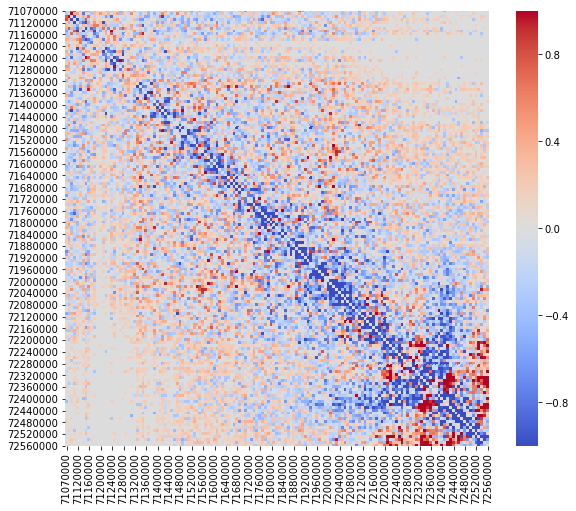

In [201]:
idx=40 ## stripe #1
resolution = 10000
graph_tem = structure[0].subgraph(idx)
df_stitch = Stich_Region_Above_Mean(graph_tem, resolution, 2)#.hub_name#.values

Back_matrix = Return_Sorted_Adjacency_Matrix(graph_tem, col_back)
Fore_matrix = Return_Sorted_Adjacency_Matrix(graph_tem, col_fore)
Diff_matrix = Fore_matrix-Back_matrix

plt.figure(figsize=(9.5,8))
#plt.figure(figsize=(5,4))
dynamic_range=1
sns.heatmap(Diff_matrix, cmap='coolwarm', vmin=-dynamic_range, vmax=dynamic_range)

## graph visulization

In [31]:
def graph_plot_saveas(_g_for_plot, _save_format):
    # Plot Parameters
    visual_style = {}
    Num_vertex=len(_g_for_plot.vs())
    Num_edge=len(_g_for_plot.es())
    vertex_size=20
    visual_style["vertex_size"] = vertex_size
    #visual_style["vertex_color"] = [color_dict[gender] for gender in g.vs["gender"]]
    if ("name" in _g_for_plot.vs.attributes()):
        visual_style["vertex_label"] = _g_for_plot.vs["name"]
    if ("size" in _g_for_plot.vs.attributes()):
        visual_style["vertex_size"] = _g_for_plot.vs["size"]
    if ("weight" in _g_for_plot.es.attributes()):
        print ("weighted edge")
        #visual_style["edge_width"] =  [float(i)/10.0 for i in g_for_plot.es["weight"]]
        #visual_style["edge_color"] =  
    
        #list(preprocessing.scale(g_for_plot.es["weight"]))  half of edges not shown
    visual_style["layout"] = _g_for_plot.layout("kk")
    
    len_box=(20*Num_vertex*(vertex_size**2))**0.5
    print (len_box)
    visual_style["bbox"] = (len_box, len_box)
    visual_style["margin"] = 40
    
    #save_format: [SVG, PDF and PNG]
    ig.plot(_g_for_plot, "network."+_save_format, **visual_style)
    _g_for_plot.vs['label']=''
    ig.plot(_g_for_plot, "network_nolabel."+_save_format, **visual_style)
    return None

from operator import add

def Visualization_Graph(_sub_graph_test, _plot_name):
    ### Mark Promoter in graph with gene_id
    graph_plot = _sub_graph_test
    #sub_graph_test.vs.select(Promoter_gt=0)['label'] = sub_graph_test.vs.select(Promoter_gt=0)['Promoter_gene_id']

    #color_dict = {"Tcf1":"red", "None": "gray"}
    #shape_dict ={'Promoter': 'circular', 'Enhancer':'arrow-up', 'Enhancer_Down':'arrow-down',
    #'Enhancer_Up':'arrow-up', 'None':'hidden'} 

## Default
    graph_plot.vs["color"] = "gray"
    graph_plot.es["color"] = "rgb(192,192,192)"
    graph_plot.vs["shape"] = "hidden"
    graph_plot.vs["size"] = 40
    graph_plot.vs["label"] = ''
    

    # high priority will be put in the end
    if ( 'K27ac' in graph_plot.vs.attributes()):
        graph_plot.vs.select(K27ac_gt=0)["shape"] = 'diamond'
       # graph_plot.vs.select(K27ac_gt=0)['label'] = [str('logFC: ')+str(round(x,2)) for x in graph_plot.vs.select(K27ac_gt=0)['K27ac_FC_K27ac_logFC']]
    
    ## DNase Priority 2
    if ( 'DNase' in graph_plot.vs.attributes()):
        graph_plot.vs.select(DNase_FC_logFC_gt=0)["shape"] = 'arrow-up'
        graph_plot.vs.select(DNase_FC_logFC_lt=0)["shape"] = 'arrow-down'
        
        #graph_plot.vs.select(DNase_FC_logFC_lt=-1)["color"] = "rgb(30,144,255)" # blue
        #graph_plot.vs.select(DNase_FC_logFC_gt=1)["color"] = "rgb(255,0,0)" # red
        
        graph_plot.vs.select(Diff_DNase_Diff_DNase="WT")["color"] = "rgb(30,144,255)" # blue
        graph_plot.vs.select(Diff_DNase_Diff_DNase="DKO")["color"] = "rgb(255,0,0)" # red
        #graph_plot.vs.select(DNase_gt=0)["size"] = [1+abs(x) * 20 for x in graph_plot.vs.select(DNase_gt=0)['DNase_FC_logFC']]
        #graph_plot.vs.select(K27ac_gt=0)['label'] = [str(round(x,2)) for x in graph_plot.vs.select(K27ac_gt=0)['K27ac_FC_K27ac_logFC']]

        #graph_plot.vs.select(DNase_gt=0)['label'] = [ round(x,2)  for x in graph_plot.vs.select(DNase_gt=0)['DNase_FC_logFC']]
    ## Promoter Priority 1
    
    if ( 'Promoter' in graph_plot.vs.attributes()):
        graph_plot.vs.select(Promoter_gt=0)['shape'] ='circular'
        graph_plot.vs.select(Promoter_gt=0)['label'] = graph_plot.vs.select(Promoter_gt=0)['Promoter_gene_id'] 
        graph_plot.vs.select(Promoter_gt=0)["size"] = 60
    if ( 'Tcf1' in graph_plot.vs.attributes()):   
        graph_plot.vs.select(Tcf1_gt=0)['label'] = [str(s) + '+'for s in graph_plot.vs.select(Tcf1_gt=0)['label']]
    if ( 'Tcf1_motif' in graph_plot.vs.attributes()):   
        graph_plot.vs.select(Tcf1_motif_gt=0)['label'] = [str(s) + '_M+'for s in graph_plot.vs.select(Tcf1_motif_gt=0)['label']]
    
    list_label = graph_plot.vs['label']
    list_loc = ['\n'+str(x).split(":")[1].split("-")[0][:-4] for x in graph_plot.vs['name'] ]
    graph_plot.vs['label'] = list(map(add, list_label, list_loc))
    ## convert Genomic Region to shape code 
    graph_plot.vs['name']=''
    #graph_plot_saveas(graph_plot, _plot_name+'.PNG')
    
    return graph_plot
### End of Visulization

# An exmaple of A graph hub

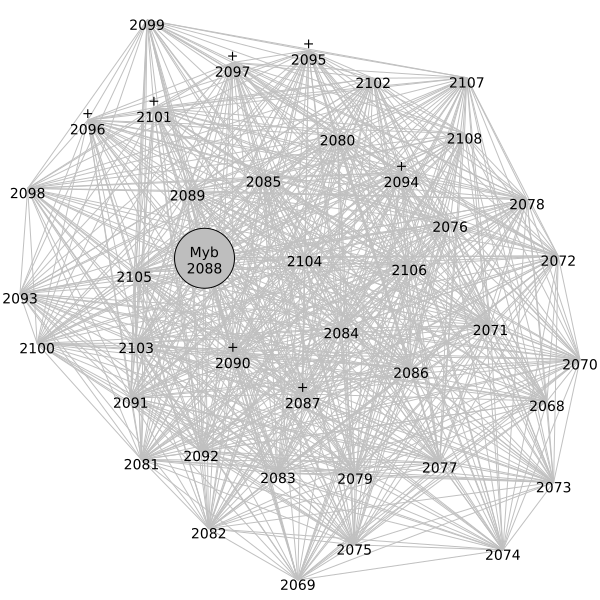

In [33]:
idx=27075
graph_tem = structure[0].subgraph(idx)
return_graph_tem = Visualization_Graph(graph_tem, 'hub_'+str(idx))
#graph_plot_saveas(return_graph_26457, 'png')
ig.plot(return_graph_tem)

array(['chr10:20800000-20810000', 'chr10:20860000-21060000'], dtype=object)

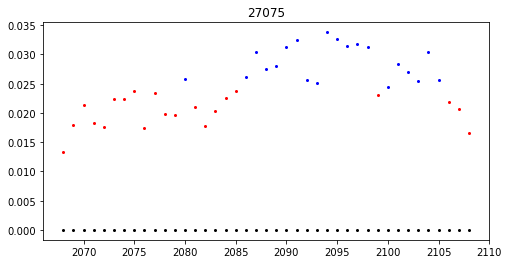

In [34]:
graph_26457 = structure[0].subgraph(idx)
graph_26457 = Graph_Pagerank(graph_26457)
df_vs_graph = convert_graph_vs_to_df(graph_26457)
df_nodes_plot = convert_cluster2bed(df_vs_graph, 'name').sort_values(by=1)

df_nodes_up_plot = df_nodes_plot[df_nodes_plot['pagerank'] > df_nodes_plot['pagerank'].mean()]
df_nodes_down_plot = df_nodes_plot[df_nodes_plot['pagerank'] < df_nodes_plot['pagerank'].mean()]

plt.subplots(nrows=1, ncols=1, figsize=(8, 4))


plt.plot(df_nodes_up_plot[1].astype(int)/10000, df_nodes_up_plot['pagerank'],'bo',  ms=2, label='idx_'+str(idx))
plt.plot(df_nodes_down_plot[1].astype(int)/10000, df_nodes_down_plot['pagerank'],'ro',  ms=2, label='idx_'+str(idx))
#plt.plot(df_nodes_plot[1].astype(int)/10000, df_nodes_plot['pagerank'],'r--' )
plt.plot(df_nodes_plot[1].astype(int)/10000, np.zeros(len(df_nodes_plot[1])),'ko',  ms=2, label='idx_'+str(idx))
#break
#plt.legend(off)
plt.title(idx)

Stich_Region_Above_Mean(graph_26457, 10000, 2).hub_name.values

In [ ]:
ch='chr10'
start=19630000
end = 20660000
df_nodes_plot[(df_nodes_plot[0]==ch)&(df_nodes_plot[1].astype(int)>=start)&(df_nodes_plot[2].astype(int)<=end)].head(3)

### Get Pvalue for given region

In [21]:
def Return_Pvalue_For_Given_Graph(_df_region, _resolution, _matrix):
    df_region = _df_region
    df_regionh_bed = convert_cluster2bed(df_region, 'hub_name').sort_values(by=1)
    resolution = _resolution
    matrix_for_test = _matrix
    
    ## convert each region into bins
    idx_regs = []
    for name_stitch in df_region.hub_name:
        region_loc= name_stitch.split(":")[1].split("-")
        idx_reg = []
        for idx in matrix_for_test.index:
            if ((idx>=int(region_loc[0]))&(idx<=int(region_loc[1]))):
                idx_reg.append(idx)
        idx_regs.append(idx_reg)

    pvalue_region= []
    for i in range(len(idx_regs)):
        for j in range(i+1):
            part_matrix_for_test = matrix_for_test.loc[idx_regs[i],:].T.loc[idx_regs[j], :]
            pvalue_tem = Pvalue_Rank_Test_Matrix(part_matrix_for_test)
            pvalue_region.append([df_region.hub_name[i],df_region.hub_name[j],-np.log10(pvalue_tem)])


    return pd.DataFrame(data=pvalue_stripe, columns=['reg1', 'reg2', '-log10(pvalue)']).sort_values('-log10(pvalue)', ascending=False)


,3300000,3320000,3330000,3340000
3300000,0.0,11.5,-1.5,-7.0
3320000,11.5,0.0,5.5,5.0
3330000,-1.5,5.5,0.0,6.0
3340000,-7.0,5.0,6.0,0.0


## An example of calculating Stripe between two given regions in a graph

In [234]:
#df_vs[df_vs['Promoter_gene_id']=='Dennd2d'].membership
#df_vs[df_vs['Promoter_gene_id']=='Myb'].membership
df_vs[df_vs['name']=='19:34620000-34630000'].membership


234062    45438
Name: membership, dtype: int64

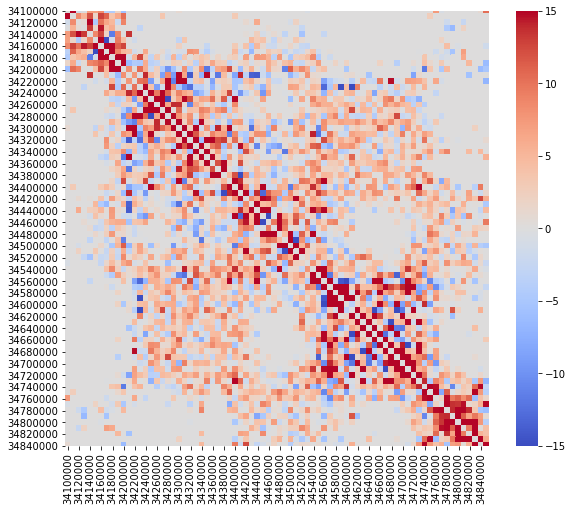

In [235]:
idx=45438 ## stripe #1
resolution = 10000
graph_26457 = structure[0].subgraph(idx)
df_stitch = Stich_Region_Above_Mean(graph_26457, resolution, 2)#.hub_name#.values

WT_matrix = Return_Sorted_Adjacency_Matrix(graph_26457, 'WT')
DKO_matrix = Return_Sorted_Adjacency_Matrix(graph_26457, 'DKO')
Diff_matrix = WT_matrix-DKO_matrix

plt.figure(figsize=(9.5,8))
#plt.figure(figsize=(5,4))
dynamic_range=15
sns.heatmap(Diff_matrix, cmap='coolwarm', vmin=-dynamic_range, vmax=dynamic_range)



,reg1,reg2,-log10(pvalue)
0,chr10:104640000-105130000,chr10:104640000-105130000,inf
1,chr6:70880000-71410000,chr6:70880000-71410000,inf
2,chr9:107130000-107650000,chr9:107130000-107650000,inf
3,chr1:39030000-39620000,chr1:39030000-39620000,inf
4,chr16:18240000-18840000,chr16:18240000-18840000,inf
...,...,...,...
12006,chr16:13320000-13530000,chr16:11560000-11630000,10.002324
12007,chr5:13540000-13570000,chr5:13330000-13500000,10.001989
12008,chr4:48070000-48150000,chr4:47580000-47720000,10.001044
12009,chr4:66900000-67000000,chr4:66800000-66880000,10.000378


In [53]:
df_tem = pd.read_csv('/home/xli/Data/HiCHub/Bcell/Resting_vs_Active_WT24h_bp/75808_A_B_24h_WT_specific_regions_new.bed', sep='\t')
df_tem = df_tem[df_tem['-log10(pvalue)']>50]
df_regions1 = convert_cluster2bed(df_tem, 'reg1').sort_values(by=1)
df_regions2 = convert_cluster2bed(df_tem, 'reg2').sort_values(by=1)
df_regions = df_regions1.append(df_regions2)
df_regions.loc[:, [0,1,2, '-log10(pvalue)']].drop_duplicates().to_csv('Actived_B_24_WT_specific.bed', sep='\t', index=None)

Text(0, 0.5, '-Log10_PValue')

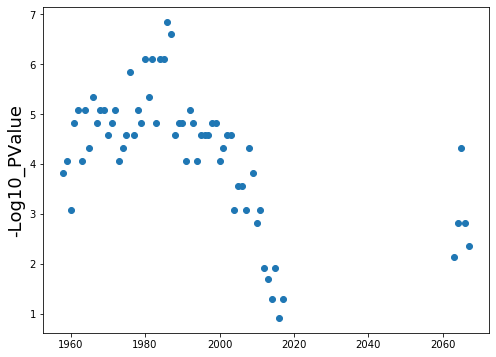

In [1384]:
pvalue_stripe= []
for i in range(len(Diff_matrix)):
    part_matrix_for_test = Diff_matrix.iloc[:,i]
    pvalue_tem = Pvalue_Rank_Test_Matrix(part_matrix_for_test)
    pvalue_stripe.append([Diff_matrix.iloc[:,i].name,pvalue_tem])
    
df_tem = pd.DataFrame(data=pvalue_stripe, columns=['reg1', 'pvalue'])#.plot()#.sort_values('pvalue')

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
plt.scatter(df_tem.reg1/10000, -np.log10(df_tem.pvalue))
ax.set_ylabel('-Log10_PValue', fontsize=18)

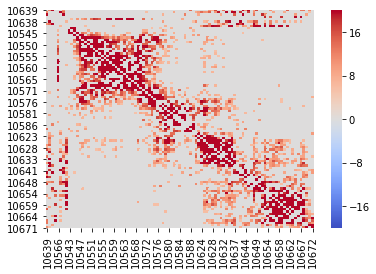

In [1262]:
## backup
graph_26457 = structure[0].subgraph(idx)
graph_tem = graph_26457
idx_name = [str(x).split(":")[1].split("-")[0][:-4] for x in graph_tem.vs['name'] ]
matrix_WT = pd.DataFrame(data=graph_tem.get_adjacency(attribute='weight'), columns=idx_name, index=idx_name)
matrix_DKO = pd.DataFrame(data=graph_tem.get_adjacency(attribute='DKO'), columns=idx_name, index=idx_name)
matrix_diff = matrix_WT-matrix_DKO

 #plt.imshow(matrix_diff, vmin=0, vmax=30, origin ='upper')
sns.heatmap(matrix_WT, cmap='coolwarm', vmin=-20, vmax=20)
#plt.colorbar()

In [148]:
geneid='Myb'
depth=3
return_graph = Return_Graph_of_Gene(graph_processed, geneid, depth)
return_graph_a = Visualization_Graph(return_graph, 'Myb_D'+str(depth))
#return_graph.vs.select(K27ac_gt=0)['K27ac']
#return_graph.vs['shape']

weighted edge
2590.7527863538044


## Tcf1 Hub 

/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


Fit Function y = a*np.exp(-b*x) + c
[2.59170352e+00 9.10980755e-04 1.96231611e+00]


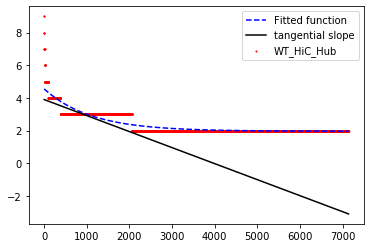

Tangential Point x: 964


0                                 chr16
1                              23450000
2                              23900000
hub_name        chr16:23450000-23900000
Num_vertices                          3
Name: 964, dtype: object

In [64]:
#df_WT_Hub_top_1200 = df_WT_Hub_top_1200.reset_index().drop('index', axis=1)
y_data = df_WT_Hub_top_1200.Num_vertices#.max()
x_data = df_WT_Hub_top_1200.index#.max()

slope = (y_data.max()-y_data.min())/x_data.max()

from scipy import optimize

def func_exp(x, a, b, c):
    return a*np.exp(-b*x) + c

def func_line(x, a, b):
    return a+b*x

params, params_covariance = optimize.curve_fit(func_exp, x_data, y_data)#,p0=[2, 2])


print ("Fit Function y = a*np.exp(-b*x) + c")
print(params)

plt.figure(figsize=(6, 4))
plt.scatter(x_data, y_data, label='WT_HiC_Hub', s=1, c='red')
plt.plot(x_data, func_exp(x_data, params[0], params[1],  params[2]),'b--',  ms=5,  label='Fitted function')

x_data_plot = x_data[0:8000]
plt.plot(x_data_plot, func_line(x_data_plot, 3.9, -slope),'k-',  ms=5,  label='tangential slope')

plt.legend(loc='best')

plt.show()

cut_point = int(-np.log(slope/(params[0]*params[1]))/(params[1]))
print ("Tangential Point x: " + str(cut_point)) 

df_WT_Hub_top_1200.iloc[cut_point,:]

In [143]:
PATH_FEATURES = '/home/xli/Data/Haihui/CD8-HP/Summary/'


pvalue=0.00001


for pvalue in [10**-7]:#,10**-8,10**-9,10**-10]:
    PATH_GENE_Promoter=PATH_FEATURES+'G_1172_Signature_DEGs_promoter_region.bed'
    Feature_Promoter=BedTool(PATH_GENE_Promoter).sort()

    df_WT_Hub = pd.read_csv(PATH_FEATURES+'H_47894_WT_hubs_filtered_by_density_0.5.bed', sep='\t')
    df_WT_Hub = df_WT_Hub[df_WT_Hub['pvalue']<pvalue]

    df_WT_Hub =df_WT_Hub.rename(columns={'#0':'chr','1':'start','2':'end'})

    ## Associated with Genes
    Feature_WT_Hub = BedTool.from_dataframe(df_WT_Hub).sort()
    Feature_Hub_promoter = Feature_WT_Hub.intersect(Feature_Promoter, wa=True, wb=True)

    df_WT_Hub_Promoter = pd.read_csv(Feature_Hub_promoter.fn, sep='\t', header=None).sort_values(5, ascending=False)
    df_WT_Hub_Promoter = df_WT_Hub_Promoter.rename(columns={9:'gene_id'})

    PATH_FEATURES = '/home/xli/Data/Haihui/CD8-HP/Summary/'
    df_expression = pd.read_csv(PATH_FEATURES+'gene_promoter_with_expression.bed', sep='\t')

    df_WT_Hub_Promoter = df_WT_Hub_Promoter.merge(df_expression.loc[:,['gene_id','log2(fold_change)']], on='gene_id')

    df_DKO_Hub = pd.read_csv(PATH_FEATURES+'H_45552_DKO_hubs_filtered_0_5.bed', sep='\t')
    df_DKO_Hub =df_DKO_Hub.rename(columns={'#0':'chr','1':'start','2':'end'})
    df_DKO_Hub = df_DKO_Hub[df_DKO_Hub['pvalue']<pvalue]
    ## Associated with Genes
    Feature_DKO_Hub = BedTool.from_dataframe(df_DKO_Hub).sort()

    Feature_Hub_promoter = Feature_DKO_Hub.intersect(Feature_Promoter, wa=True, wb=True)

    df_DKO_Hub_Promoter = pd.read_csv(Feature_Hub_promoter.fn, sep='\t', header=None).sort_values(5, ascending=False)
    df_DKO_Hub_Promoter = df_DKO_Hub_Promoter.rename(columns={9:'gene_id'})#.shape

    PATH_FEATURES = '/home/xli/Data/Haihui/CD8-HP/Summary/'
    df_expression = pd.read_csv(PATH_FEATURES+'gene_promoter_with_expression.bed', sep='\t')
    df_DKO_Hub_Promoter = df_DKO_Hub_Promoter.merge(df_expression.loc[:,['gene_id','log2(fold_change)']], on='gene_id')


    df_WT_Hub_Gene = df_WT_Hub_Promoter.loc[:, ['gene_id', 'log2(fold_change)']].drop_duplicates()
    df_DKO_Hub_Gene = df_DKO_Hub_Promoter.loc[:, ['gene_id', 'log2(fold_change)']].drop_duplicates()
    Num_DKO_hub_Up = len(df_DKO_Hub_Promoter[df_DKO_Hub_Promoter.loc[:, 'log2(fold_change)'].astype(float)>0])
    Num_DKO_hub_Down = len(df_DKO_Hub_Promoter[df_DKO_Hub_Promoter.loc[:, 'log2(fold_change)'].astype(float)<0])

    Num_WT_hub_Up = len(df_WT_Hub_Promoter[df_WT_Hub_Promoter.loc[:, 'log2(fold_change)'].astype(float)>0])
    Num_WT_hub_Down = len(df_WT_Hub_Promoter[df_WT_Hub_Promoter.loc[:, 'log2(fold_change)'].astype(float)<0])

    df_Hub = df_WT_Hub_Promoter.append(df_DKO_Hub_Promoter)
    
    print (Num_WT_hub_Down, Num_WT_hub_Up, Num_WT_hub_Down/Num_WT_hub_Up)

    print (Num_DKO_hub_Up, Num_DKO_hub_Down, Num_DKO_hub_Up/Num_DKO_hub_Down)

29 13 2.230769230769231
28 6 4.666666666666667


In [116]:
from scipy.stats import wilcoxon

In [ ]:
### find interaction in subgraph completely. which requires a 100% overlap 

In [158]:
df_Feature_Hub_interaction.head(1)

,0,1,2,3,4,5,6,7,8,gene_id,10,log2(fold_change),#chr,0,1,WT,DKO
0,chr9,69300000,69400000,chr9:69300000-69400000,10,9.625824e-08,chr9,69300489,69302490,Anxa2,promoter,1.47147,chr9,69310000,69320000,142.09915,122.16448


In [157]:
## Associated Hub with Target Gene
PATH_interaction=PATH_FEATURES+'H_4604308_hic_pooled_interaction_KR_Sum_gt10.bed'
df_inter = pd.read_csv(PATH_interaction, sep="\t").fillna(0)
df_inter = df_inter[df_inter['0']!=df_inter['1']]
df_inter.loc[:,'#chr']= 'chr'+df_inter.loc[:,'#chr'].astype(str)

#df_Hub_for_plot = df_Hub.loc[:,['0','1','2','3','']]

Feature_top_hub = BedTool.from_dataframe(df_Hub)#.sort()
Feature_interaction = BedTool.from_dataframe(df_inter)
Feature_Hub_interaction = Feature_top_hub.intersect(Feature_interaction, wa=True, wb=True, F=1.0)

col_name = df_Hub.columns.append(df_inter.columns)
df_Feature_Hub_interaction = pd.read_csv(Feature_Hub_interaction.fn, sep='\t', names=col_name)

df_Feature_Hub_interaction_group = df_Feature_Hub_interaction.groupby('gene_id')

/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
output_gene_with_hub_Median = list()#
for gene in df_Feature_Hub_interaction_group:
    #print (gene[0])
    df_gene = gene[1]
    gene_HiC_median = np.log2(df_gene.loc[:,'DKO'].replace(0,0.1) / df_gene.loc[:,'WT'].replace(0,0.1) ).median()
    
    gene_expression = df_gene.loc[:, 'log2(fold_change)'].unique()[0]
    
    output_gene_with_hub_Median.append([gene[0], gene_expression, gene_HiC_median])
df_plot = pd.DataFrame(data=output_gene_with_hub_Median, columns=['gene_id','logFC_Expression','logFC_HiC'])
df_plot.to_csv('/home/xli/Data/Haihui/CD8-HP/Summary/H_Diff_Hub_associated_genes.txt', sep='\t', index=None)

/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/xli/.conda/envs/py3_lx/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


['1190002N15Rik: 1.05617', '2610020H08Rik: 1.17528', '5830411N06Rik: 4.56031', '5830432E09Rik: 0.361332', 'Aqp11: 1.45563', 'Art2a-ps: 1.58822', 'Ccl3: 5.23609', 'Ccl4: 4.1426', 'Ccl6: 5.00532', 'Ccnd1: 0.41456', 'Cd163l1: 4.87878', 'Cd33: 1.14071', 'Chsy1: 1.08932', 'Cldnd2: 1.60752', 'Ctsd: 0.618078', 'Gm4759: 0.547655', 'Ifitm10: 0.896281', 'Lair1: 1.33937', 'Mrgpre: 1.44836', 'Mrvi1: 1.00443', 'Myo1f: 1.95238', 'Napsa: 1.71517', 'Nkg7: 0.774371', 'Osbpl5: 1.63032', 'Pou2f2: 0.579261', 'Pram1: 0.313444', 'Prkcg: 1.96877', 'Prrt2: 1.58626', 'Slamf7: 2.60294', 'Spib: 1.29213', 'Tyrobp: 4.39733']


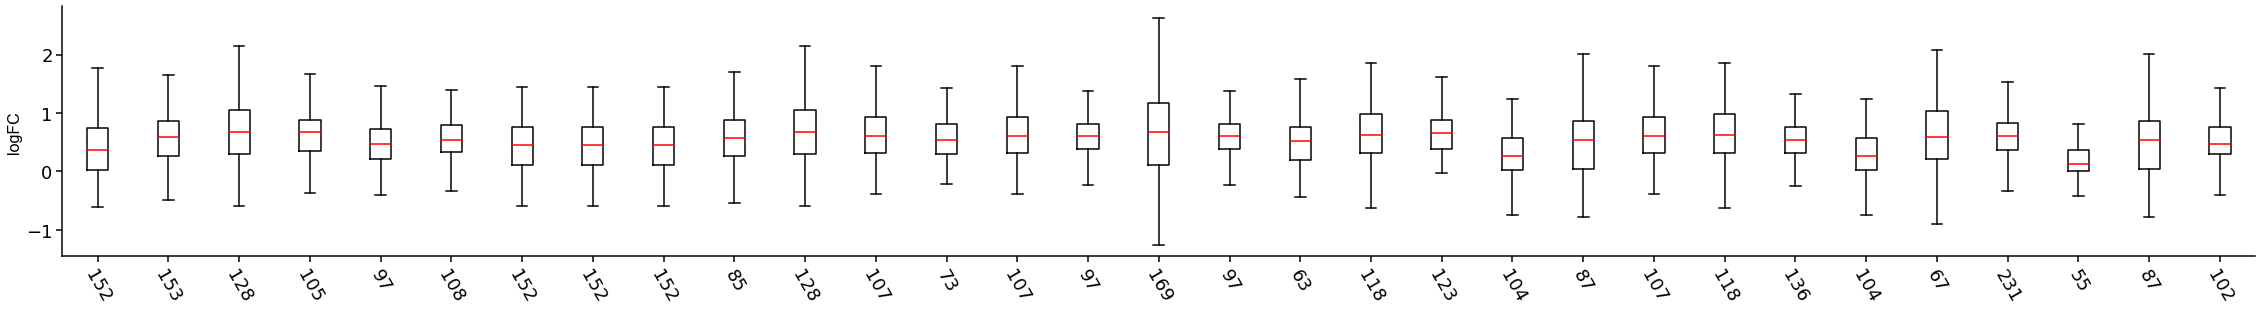

In [111]:
all_data = []
columns_name = []

pic_idx = 0
range_len=300
rangex = range(pic_idx*range_len, (pic_idx+1)*range_len,1)
i=0
for df_gene in df_Feature_Hub_interaction_group:
    if (i in rangex):
        df_gene_plot = df_gene[1]
        if ( len(df_expression[df_expression['gene_id']== df_gene[0]]) ==0):
            continue
        expression = df_expression[df_expression['gene_id']== df_gene[0]].iloc[0,7]
        if (float(expression)>0):
            df_gene_plot.loc[:, 'logFC'] = np.log2(df_gene_plot.loc[:,'DKO'].replace(0,0.1) / df_gene_plot.loc[:,'WT'].replace(0,0.1) )
            if (df_gene_plot.loc[:, 'logFC'].quantile(0.25)>0):
                all_data.append(df_gene_plot.loc[:, 'logFC'])
                columns_name.append( df_gene[0]+': '+expression)
    i+=1
    if (i == (pic_idx+1)*range_len):
        break

box_plot_for_haihui(all_data, 'logFC')
print(columns_name)

Text(0, 0.5, 'Number of Vertices')

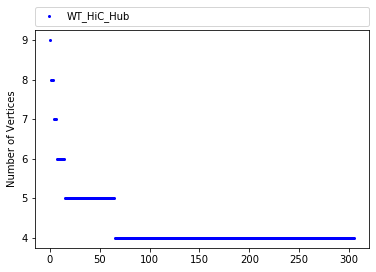

In [83]:
df_WT_Hub_top_1200 = convert_cluster2bed(df_WT_Hub, 'hub_name')
threshold = 4
top_index = df_WT_Hub_top_1200[df_WT_Hub_top_1200['Num_vertices']>=threshold].index
df_plot = df_WT_Hub_top_1200[df_WT_Hub_top_1200['Num_vertices']>=threshold].reset_index().drop('index', axis=1)
#plt.xlim(0,1000)
#plt.plot( df_DKO_Hub.index, df_DKO_Hub.Num_vertices, 'ro', ms=2, label='DKO_HiC_Hub')
plt.plot( df_plot.index, df_plot.Num_vertices, 'bo', ms=2, label='WT_HiC_Hub')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylabel('Number of Vertices')

In [101]:
## Find core from Hubs
## Top
top_hub_index = top_index.values
df_vs_inside_cluster_Top = pd.DataFrame()
for hub_idx in top_hub_index:
    df_vs_cluster = df_WT_Hub_Groups.get_group(hub_idx)
    if (df_vs_cluster.shape[0]>2):
        df_vs_inside_cluster = convert_cluster2bed(df_vs_cluster, 'name')
        df_vs_inside_cluster_Top = df_vs_inside_cluster_Top.append(df_vs_inside_cluster.nlargest(1, 'degree'))
        #df_vs_inside_cluster_Bottom = df_vs_inside_cluster_Bottom.append(df_vs_inside_cluster.nsmallest(1, 'degree'))



## Bottom
df_WT_Hub_Bottom = convert_cluster2bed(df_WT_Hub.nsmallest(len(top_hub_index), 'Num_vertices'), 'hub_name')
bottom_hub_index = df_WT_Hub_Bottom.index.values
df_vs_inside_cluster_Bottom = pd.DataFrame()
for hub_idx in bottom_hub_index:
    df_vs_cluster = df_WT_Hub_Groups.get_group(hub_idx)
    if (df_vs_cluster.shape[0]>0):
        df_vs_inside_cluster = convert_cluster2bed(df_vs_cluster, 'name')
        df_vs_inside_cluster_Bottom = df_vs_inside_cluster_Bottom.append(df_vs_inside_cluster.nsmallest(1, 'degree'))

In [51]:
#df_vs_inside_cluster_Top.to_csv('/home/xli/Data/Haihui/CD8-HP/Summary/venn/venn2/1497_gt16_Top_Hub_core.bed',
#                                sep='\t', index=None)


Enriched Feature Number: 15303
Prob:  0.9114063659987567


(17355.000021348325, 15303, 0.8817631795549313)

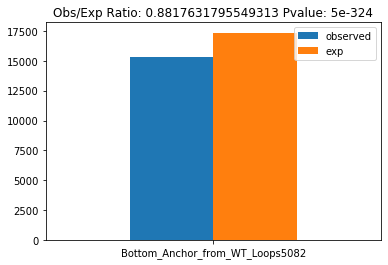

In [72]:
#df_WT_Hub = pd.read_csv(PATH_FEATURES+'H_47894_hubs_No_filtered.bed',sep='\t')
#df_tem = df_WT_Hub[df_WT_Hub.Num_vertices==1]
#df_tem   = df_vs_inside_cluster_Bottom
#df_tem   = df_vs_inside_cluster_Top


Name = "Bottom_Anchor" + "_from_WT_Loops"
Path_Region = BedTool.from_dataframe(df_WT_Hub_top_1200[df_WT_Hub_top_1200['Num_vertices']==2]).fn

Features_Return_exp_and_obser(Path_Tcf1, Path_Region, 0, Name)

In [126]:
df_vs_inside_cluster_Top.head(1)

pro_Top = 10000*(df_vs_inside_cluster_Top.loc[:, 'Tcf1'] / (df_vs_inside_cluster_Top[2].astype(float)-df_vs_inside_cluster_Top[1].astype(float))).sum()


pro_Bottom = 10000*(df_vs_inside_cluster_Bottom.loc[:, 'Tcf1'] / (df_vs_inside_cluster_Bottom[2].astype(float)-df_vs_inside_cluster_Bottom[1].astype(float))).sum()

print (pro_Top)
print (pro_Bottom)

df_vs_inside_cluster_Top.head(1)

254.20000000000002
115.40000000000002


,0,1,2,degree,name,Promoter,Promoter_gene_id,Tcf1,Tcf1_logFC,pagerank,membership
10560,chr3,115500000,115510000,5,3:115500000-115510000,0,0,4,12.269655,0.000113,4770


In [ ]:
### limit

P_value is: 1.6e-103
['306_Core_From_WT_Loop_Hub', '306_bottom_From_WT_Loop_Hub']


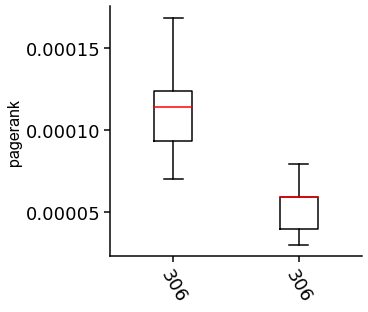

In [129]:
all_data = [ 
df_vs_inside_cluster_Top.loc[:, 'pagerank'], 
df_vs_inside_cluster_Bottom.loc[:, 'pagerank']]

box_plot_for_haihui(all_data, 'pagerank')

i=0
columns_name = [str(len(all_data[0+i]))+'_Core_From_WT_Loop_Hub', str(len(all_data[1+i]))+'_bottom_From_WT_Loop_Hub'
                    ]

pvalue=stats.mannwhitneyu(all_data[0], all_data[1], alternative='greater')[1]
print('P_value is: %.1e' % pvalue )
print(columns_name)

In [553]:
## Define hub with Tcf1 binding.

top_1200_hub_index = df_WT_Hub_top_1200.index.values
#df_vs_inside_cluster_Top[df_vs_inside_cluster_Top['Tcf1']>0]

## Rank each cluster by number of bins
cluster_name=[]
cluster_num_vertices=[]
cluster_num_Tcf1=[]
cluster_hub_idx = [] 
for hub_idx in top_1200_hub_index:
   #print (hub_idx)
    df_vs_cluster = Cluster_Filter_by_Denisty(df_WT_Hub_Groups.get_group(hub_idx), 'name', 'pagerank', 1) #df_WT_Hub_Groups.get_group(hub_idx)
    df_cluster_coordiante = df_vs_cluster['name'].str.split(r"\:|-",expand=True)
    cluster_coordinate = 'chr'+df_cluster_coordiante.iloc[0,0]+':'+str(df_cluster_coordiante.iloc[:,1].astype(int).min())+'-'+str(df_cluster_coordiante.iloc[:,2].astype(int).max())
    cluster_name.append(cluster_coordinate) ##0: cluster name
    cluster_num_vertices.append(len(df_vs_cluster)) # 1: num_vertices
    cluster_num_Tcf1.append(df_vs_cluster['Tcf1'].sum())
    cluster_hub_idx.append(hub_idx)
    #break

df_cluster_output = pd.DataFrame(data={'hub_name':cluster_name, 'hub_idx':cluster_hub_idx ,'Num_vertices':cluster_num_vertices, 'Num_Tcf1':cluster_num_Tcf1})
df_cluster_output['Tcf1/Vertices'] = df_cluster_output['Num_Tcf1']/df_cluster_output['Num_vertices'] 
df_cluster_output = df_cluster_output.sort_values('Tcf1/Vertices', ascending=False)
    
#pd.DataFrame(data = df_vs_cluster.Promoter_gene_id.unique()).to_csv('Test_Genelist.txt', index=None, header=None)

KeyError: 'Tcf1'

In [75]:
sort_col = 'Num_Tcf1'
#sort_col = 'Tcf1/Vertices'
df_cluster_output.sort_values(sort_col, ascending=False).head(5)

,hub_name,hub_idx,Num_vertices,Num_Tcf1,Tcf1/Vertices
5,chr19:45240000-47260000,11945,130,90,0.692308
13,chr19:5740000-7740000,11734,116,76,0.655172
3,chr9:43790000-45370000,6620,140,68,0.485714
33,chr17:83660000-85120000,11266,97,62,0.639175
6,chr19:10460000-12330000,11751,129,60,0.465116


P_value is: 1.0e+00
['1200_Top_1200_Core', '1200_Bottom_1200']


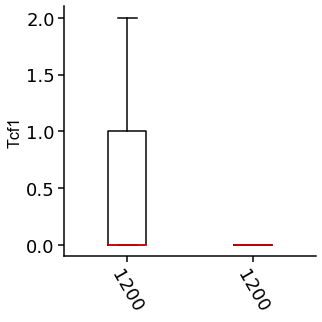

In [52]:
all_data = [ 
df_vs_inside_cluster_Top.loc[:, 'Tcf1'], 
df_vs_inside_cluster_Bottom.loc[:, 'Tcf1'] ]
box_plot_for_haihui(all_data, 'Tcf1')

i=0
columns_name = [str(len(all_data[0+i]))+'_Top_1200_Core',
                     str(len(all_data[1+i]))+'_Bottom_1200']

pvalue=stats.mannwhitneyu(all_data[0], all_data[1], alternative='less')[1]
print('P_value is: %.1e' % pvalue )
print(columns_name)

Enriched Feature Number: 142
Prob:  0.1010617845237728


(121.27414142852737, 142, 1.170900888906209)

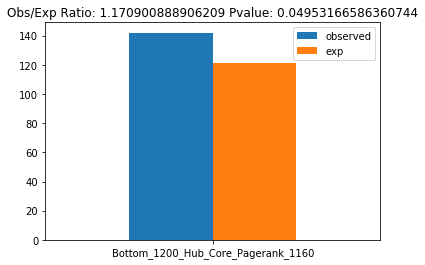

In [66]:
#df_WT_Hub_top_1200 = convert_cluster2bed(df_WT_Hub.nlargest(1200, 'Num_vertices'), 'hub_name')
Path_Region = BedTool.from_dataframe(df_vs_inside_cluster_Bottom).fn
Features_Return_exp_and_obser(Path_Region, PATH_FEATURES+'venn/venn2/naive-WT-CD8_Gateway_SuperEnhancers.bed', 0, 'Bottom_1200_Hub_Core_Pagerank_')

In [170]:
df_WT_Hub.shape
df_DKO_Hub.shape

(194, 6)

['174_WT_SE.bed', '194_Top_DKO_Hub.bed']
Input Two, Continue.


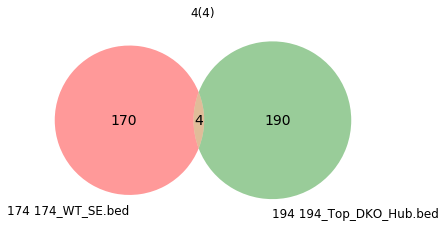

0

In [174]:
Path_Venn='/home/xli/Data/Haihui/CD8-HP/Summary/venn/venn2'

#df_WT_Hub.to_csv(Path_Venn+'/221_Top_WT_Hub.bed', sep='\t', index=None, header=None)
#df_DKO_Hub.to_csv(Path_Venn+'/194_Top_DKO_Hub.bed', sep='\t', index=None, header=None)

Generate_Venn_Diagram(Path_Venn, Path_Venn)

In [71]:
## fing Tcf1 Enrichment for each hub 

df_hub_with_Tcf1 = df_WT_Hub_top_1200

for hub_idx in df_hub_with_Tcf1.index:
    df_cluster = df_WT_Hub_Groups.get_group(hub_idx)
    select_edge = graph_processed.es.select(_within=df_cluster.index.to_list() )
    sub_graph_test =  select_edge.subgraph()
    df_hub_with_Tcf1.loc[hub_idx,'Tcf1'] = sum(sub_graph_test.vs['Tcf1'])


KeyboardInterrupt: 

In [ ]:
df_hub_with_Tcf1.sort_values('Tcf1')

# Visualization

In [236]:
df_Tcf1_KO_Genes.nsmallest(5,columns='log2(fold_change)').gene_id.values

array(['Gm14085', 'Myb', 'Gria3', 'Slc16a5', 'Lad1'], dtype=object)

In [287]:
Myb_Graph = Return_Graph_of_Gene(g_WT_Specific, 'Myb', 3)
Visualization_Graph(Myb_Graph, 'Myb')

weighted edge
346.41016151377545


In [243]:
## Plot of a vertex and its neiborhood 
for vertex in graph_processed.vs.select(Promoter_gene_id='Crip2'):
    print(vertex.index)
    graph_select_edges = graph_processed.es[graph_processed.incident(vertex.index)]
    vs_subgraph=graph_select_edges.subgraph()

    test_subgrapph = graph_processed.induced_subgraph(vertex_set)


### Mark Promoter in graph with gene_id
    sub_graph_test = test_subgrapph
    #sub_graph_test.vs.select(Promoter_gt=0)['label'] = sub_graph_test.vs.select(Promoter_gt=0)['Promoter_gene_id']

    #color_dict = {"Tcf1":"red", "None": "gray"}
    #shape_dict ={'Promoter': 'circular', 'Enhancer':'arrow-up', 'Enhancer_Down':'arrow-down',
    #'Enhancer_Up':'arrow-up', 'None':'hidden'} 


    ## convert binding to color code
    sub_graph_test.vs["color"] = "gray"
    sub_graph_test.vs.select(Tcf1_gt=0)["color"] = "red"

    ## convert Genomic Region to shape code 
    sub_graph_test.vs["shape"] = "hidden"

    # high priority will be put in the end
    sub_graph_test.vs.select(K27ac_gt=0)["shape"] = 'diamond'
    sub_graph_test.vs.select(K27ac_gt=0)['label'] = ["{:.2f}".format(x) for x in sub_graph_test.vs.select(K27ac_gt=0)['K27ac_logFC']]

    sub_graph_test.vs.select(DNase_logFC_gt=0)["shape"] = 'arrow-up'
    sub_graph_test.vs.select(DNase_logFC_lt=0)["shape"] = 'arrow-down'
    
        
      
    sub_graph_test.vs.select(Promoter_gt=0)["shape"] = 'circular'

    sub_graph_test.vs.select(DNase_gt=0)["size"] = [abs(x) * 20 for x in sub_graph_test.vs.select(DNase_gt=0)['DNase_logFC']]

    
    sub_graph_test.vs.select(Promoter_gt=0)['label'] = sub_graph_test.vs.select(Promoter_gt=0)['Promoter_gene_id']
    sub_graph_test.vs.select(Promoter_gt=0)["size"] = 20
    ## convert Genomic Region to shape code 


    sub_graph_test.vs['name']=''
    graph_plot_saveas(sub_graph_test, gene_id+'.PNG')


    ### End of Visulization

36949
weighted edge
447.21359549995793


##  Explore: Using HMM to predict expression

In [268]:
_input_graph=g_WT_Specific
vs_promoter = _input_graph.vs.select(Promoter_gt=0)#.select(Tcf1_gt=0)
len(vs_promoter)

vs_idx_set=[]
for vs in vs_promoter:
    vs_idx_set.append(vs.index)

In [320]:
genelist_bin_with_promoter = vs_promoter['Promoter_gene_id']
return_graph.summary()

'IGRAPH UNW- 2 1 -- \n+ attr: DNase (v), DNase_logFC (v), K27ac (v), K27ac_logFC (v), Promoter (v), Promoter_gene_id (v), Tcf1 (v), Tcf1_logFC (v), color (v), label (v), name (v), shape (v), size (v), weight (e)'

In [497]:
i=0
# genelist_bin_with_promoter
genelist_set = genelist_bin_with_promoter
list_enhancer_signal=[]
for genelist in genelist_set:
    return_graph = Return_Graph_of_Gene(g_WT_Specific, genelist, 1)
    if (return_graph!=None):
        df_return_graph = pd.DataFrame(data= {'gene_id':return_graph.vs['Promoter_gene_id'], 'DNase_logFC':return_graph.vs['DNase_logFC'],
                                         'K27ac_logFC':return_graph.vs['K27ac_logFC'], 'Tcf1_logFC':return_graph.vs['Tcf1_logFC']})
        df_return_graph_sum = df_return_graph[df_return_graph['gene_id']==0].sum(axis=0)
        list_enhancer_signal.append([genelist, df_return_graph_sum.DNase_logFC, df_return_graph_sum.K27ac_logFC, df_return_graph_sum.Tcf1_logFC])
        #print(len(return_graph.vs))
#    Visualization_Graph(return_graph, 'test')


In [499]:
len(list_enhancer_signal)

8673

In [486]:
#Visualization_Graph(return_graph, 'test')

In [503]:
## Promoter Probability matrix
df_promoter = pd.DataFrame(data= {'gene_id':vs_promoter['Promoter_gene_id'], 'DNase_logFC':vs_promoter['DNase_logFC'],
                                 'K27ac_logFC':vs_promoter['K27ac_logFC'], 'Tcf1_logFC':vs_promoter['Tcf1_logFC']})
df_promoter = df_promoter[df_promoter.loc[:,['DNase_logFC', 'K27ac_logFC','Tcf1_logFC']].sum(axis=1)!=0]
df_promoter.head(1)
df_expression = Generate_All_Genes('/home/xli/cloud_research/PengGroup/XLi/Data/Haihui/CD8-HP/RNA_seq/CuffDiff_Jun2018/Cuffdiff_Results/DKO_0h_vs_WT_0h',0)

#df_expression = df_expression.merge(df_signature_genes, on='gene_id', how='inner')
#df_expression = df_expression[(df_expression['DKO_0h']>1) & (df_expression['WT_0h']>1) & (df_expression['p_value']<0.05)]
df_promoter = df_promoter.merge(df_expression.loc[:,['gene_id', 'log2(fold_change)']].rename(columns={'log2(fold_change)':'expression_logFC'}),
            on='gene_id', how='inner').set_index('gene_id')

### enhancer Probability matrix
df_enhancer = pd.DataFrame(data=list_enhancer_signal, columns=df_return_graph_sum.index)
df_enhancer = df_enhancer.merge(df_expression.loc[:,['gene_id', 'log2(fold_change)']].rename(columns={'log2(fold_change)':'expression_logFC'}),
            on='gene_id', how='inner').set_index('gene_id')

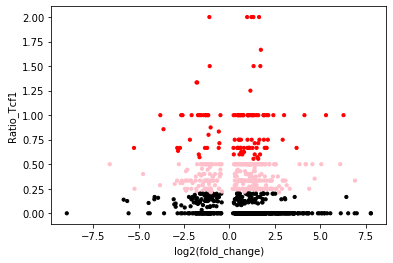

In [139]:
df_expression['color'] = df_expression['Ratio_Tcf1'].apply(lambda x : 'red' if x > 0.5 else ( 'pink' if x >0.2 else 'black'))
df=df_expression.loc[:,['log2(fold_change)','Ratio_Tcf1', 'color']]

highlight_name=''
title_name= 'Expression_vs_Tcf1_Ratio'#'logFC between  R:'+ str("{:.3f}".format(df.corr().iloc[0,1]))

df.plot.scatter(x='log2(fold_change)',  y='Ratio_Tcf1', c=df['color'], s=10)

## Calculated Score and predict 

In [86]:
graph_processed.vs.select(Promoter_gt=0)

In [91]:
def predict_expression_mode1(_input_graph):
    ## Input Graph must have attributes: "region", "binding"
    vs_promoter = _input_graph.vs.select(Promoter_gt=0)
    output_gene_with_score=list()
    for vertex in vs_promoter:
        edges_from_vs = _input_graph.es[_input_graph.incident(vertex.index)]
        vs_subgraph=edges_from_vs.subgraph()
        test_score = 0 ## for a single promoter vertex define a expression score
        for vs_region, vs_binding in zip(vs_subgraph.vs['region'], vs_subgraph.vs['binding']):
            #print (vs_region,vs_binding)
            if (vs_region == 'Enhancer_Down'): test_score+=(-1)
            elif (vs_region == 'Enhancer_Up'): test_score+=1
            if ( vs_binding=='Tcf1'): test_score*=2
            ## end
        output_gene_with_score.append( [vertex['label'], test_score])
    return output_gene_with_score

[0, 1]

# Venn

In [166]:
from matplotlib_venn import venn2
def Generate_Venn_Diagram(Raw_Path, Out_Path):
    
    INPUT_LIST = [f for f in os.listdir(Raw_Path) if not f.startswith('.')]  ## Exclude hidden file, start with .
    print (INPUT_LIST)
    if len(INPUT_LIST) == 2:
        print ('Input Two, Continue.')
        PATH_A = Raw_Path + '/' +INPUT_LIST[0]
        PATH_B = Raw_Path + '/' +INPUT_LIST[1]

    df1 = BedTool(PATH_A).sort()
    df2 = BedTool(PATH_B).sort()

    intersect_df = df1.intersect(df2, u=True)

    out = venn2(subsets=(len(df1-df2), len(df2-df1), len(df2+df1)),
              set_labels=(str(len(df1))+' '+str(INPUT_LIST[0]), str(len(df2))+' '+str(INPUT_LIST[1]) ))
    for text in out.subset_labels:
        text.set_fontsize(14)
    
    #(df1-df2).saveas(Out_Path+str(len(df1-df2))+'_specific_'+INPUT_LIST[0][0:-4]+'.bed')
    #(df2-df1).saveas(Out_Path+str(len(df2-df1))+'_specific_'+INPUT_LIST[1][0:-4]+'.bed')
    #(df1+df2).saveas(Out_Path+str(len(df1+df2))+'_overlap_'+INPUT_LIST[1][0:-4]+'.bed')
    #(df2+df1).saveas(Out_Path+str(len(df2+df1))+'_overlap_'+INPUT_LIST[1][0:-4]+'.bed')
    plt.title(str(len(df2+df1))+'('+ str( len(df1+df2)) +')' )
    plt.show()
    return 0

Generate_Venn_Diagram(PATH_FEATURES+'venn/venn2/', PATH_FEATURES+'venn/venn2/')

['174_WT_SE.bed', '221_Top_WT_Hub.bed']
Input Two, Continue.


BEDToolsError: 
Command was:

	bedtools sort -i /home/xli/Data/Haihui/CD8-HP/Summary/venn/venn2//221_Top_WT_Hub.bed

Error message was:
Unexpected file format.  Please use tab-delimited BED, GFF, or VCF. Perhaps you have non-integer starts or ends at line 1?


Text(0, 0.5, 'Number of Vertices')

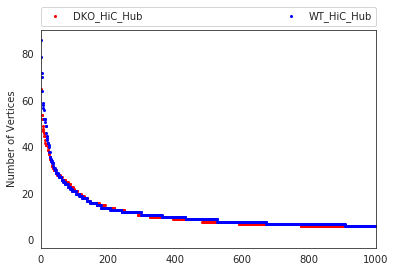

In [379]:
plt.xlim(0,1000)
plt.plot( df_DKO_Hub.index, df_DKO_Hub.Num_vertices, 'ro', ms=2, label='DKO_HiC_Hub')
plt.plot( df_WT_Hub.index, df_WT_Hub.Num_vertices, 'bo', ms=2, label='WT_HiC_Hub')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylabel('Number of Vertices')